# TESTING TIME SERIES ALGORITHMS IN A REAL-CASE SCENARIO
PREDICTING THE COLOMBIAN CURRENCY EXCHANGE RATE

### 1. INSTALL REQUIRED PACKAGES AND LIBRARIES

In [1]:
#pip install yfinance
#pip install xgboost
#pip install prophet
#pip install scikit-learn
#pip install openpyxl
#pip install scikit-learn --upgrade
#pip install statsmodels
#pip install plotly
#pip install pmdarima

In [2]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
import time

### 2. GETTING THE DATA

    2.1 Scrap from YahooFinance the series: Exchange Rate, Coffee Prices, Oil Price and S&P 500 Index

In [3]:
# Start the timer
start_time = time.time()

# Download Exchange Rate
ticker_exchange_rate = "COP=X"
exchange_data = yf.download(ticker_exchange_rate, start="2002-08-01", end="2024-12-31")
exchange_data = exchange_data[['Close']].rename(columns={'Close': 'Exchange_Rate'})

# Download Oil Prices (WTI)
ticker_oil = "BZ=F"  # Brent Crude Oil Futures
oil_data = yf.download(ticker_oil, start="2009-12-15", end="2024-12-31")
oil_data = oil_data[['Close']].rename(columns={'Close': 'Oil_Price'})

# Download S&P 500 Index
ticker_sp500 = "^GSPC"
sp500_data = yf.download(ticker_sp500, start="2009-12-15", end="2024-12-31")
sp500_data = sp500_data[['Close']].rename(columns={'Close': 'SP500_Index'})

# Download Coffee Prices
ticker_coffee = "KC=F"  # Coffee Futures
coffee_data = yf.download(ticker_coffee, start="2009-12-15", end="2024-12-31")
coffee_data = coffee_data[['Close']].rename(columns={'Close': 'Coffee_Price'})

# Merge All Data
combined_data = exchange_data.merge(oil_data, left_index=True, right_index=True, how='outer')
combined_data = combined_data.merge(sp500_data, left_index=True, right_index=True, how='outer')
combined_data = combined_data.merge(coffee_data, left_index=True, right_index=True, how='outer')

# Reset Index to make Date a column
combined_data.reset_index(inplace=True)
combined_data.rename(columns={'index': 'Date'}, inplace=True)

# Ensure the 'Date' column is in datetime format
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

# Set 'Date' as the index
combined_data.set_index('Date', inplace=True)

# Create a complete date range from the minimum to the maximum date in the dataset
full_date_range = pd.date_range(start=combined_data.index.min(), end=combined_data.index.max())

# Reindex the DataFrame to include all dates
combined_data = combined_data.reindex(full_date_range)

# Forward-fill missing values
combined_data = combined_data.ffill()

# Reset the index to bring 'Date' back as a column
combined_data.reset_index(inplace=True)

# Rename the index column to 'Date'
combined_data.rename(columns={'index': 'Date'}, inplace=True)

# Flatten the column names to remove multi-level headers
combined_data.columns = [col[0] if isinstance(col, tuple) else col for col in combined_data.columns]

# Ensure 'Date' column is named correctly
if 'Date' not in combined_data.columns:
    combined_data.rename(columns={combined_data.columns[0]: 'Date'}, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Replace values less than 400 with NaN
combined_data.loc[combined_data['Exchange_Rate'] < 400, 'Exchange_Rate'] = pd.NA

# Forward fill NaN values to replace with the closest previous non-null value
combined_data['Exchange_Rate'] = combined_data['Exchange_Rate'].fillna(method='ffill')

#Calculate the 30-day and 85-day lagged values for the Exchange Rate
combined_data['Exchange_Rate_Lag30'] = combined_data['Exchange_Rate'].shift(900)
combined_data['Exchange_Rate_Lag85'] = combined_data['Exchange_Rate'].shift(2550)

# Drop rows before 2010-01-01
combined_data = combined_data[combined_data['Date'] >= '2010-01-01']

# Reset index for cleaner presentation
combined_data.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
print(combined_data.head(10))

        Date  Exchange_Rate  Oil_Price  SP500_Index  Coffee_Price  \
0 2010-01-01    2039.000000  77.930000  1115.099976    135.949997   
1 2010-01-02    2039.000000  77.930000  1115.099976    135.949997   
2 2010-01-03    2039.000000  77.930000  1115.099976    135.949997   
3 2010-01-04    2020.900024  80.120003  1132.989990    141.850006   
4 2010-01-05    1987.000000  80.589996  1136.520020    141.000000   
5 2010-01-06    1970.500000  81.889999  1137.140015    141.600006   
6 2010-01-07    1936.800049  81.510002  1141.689941    141.899994   
7 2010-01-08    1936.900024  81.370003  1144.979980    145.350006   
8 2010-01-09    1936.900024  81.370003  1144.979980    145.350006   
9 2010-01-10    1936.900024  81.370003  1144.979980    145.350006   

   Exchange_Rate_Lag30  Exchange_Rate_Lag85  
0          1923.300049               2838.5  
1          1894.699951               2838.5  
2          1891.099976               2838.5  
3          1898.900024               2838.5  
4         

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4304\790537290.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data['Exchange_Rate'] = combined_data['Exchange_Rate'].fillna(method='ffill')


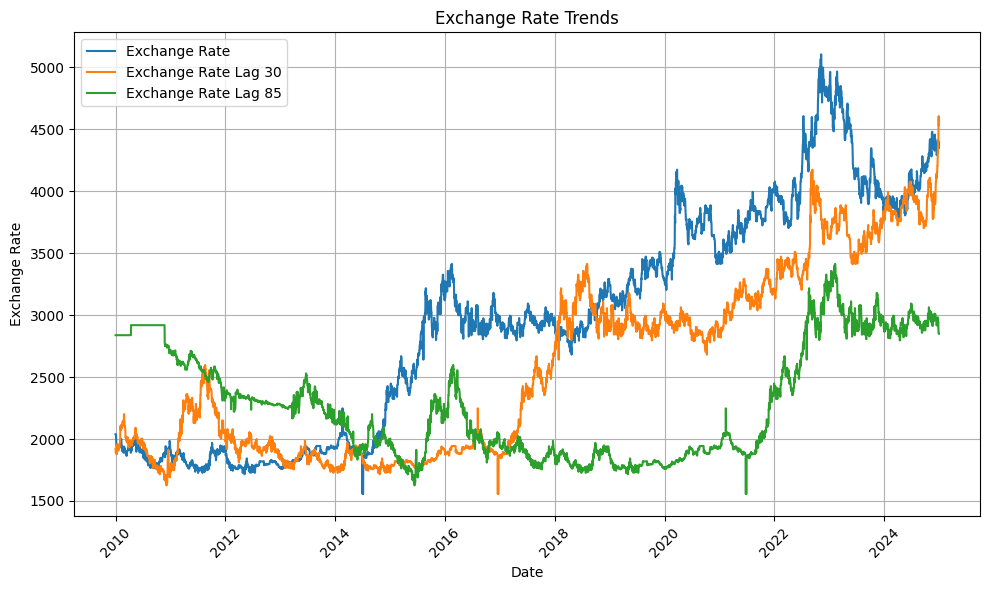

In [5]:
# Plot the lines
plt.figure(figsize=(10, 6))  # Adjust the size of the figure if needed
plt.plot(combined_data['Date'], combined_data['Exchange_Rate'], label='Exchange Rate')
plt.plot(combined_data['Date'], combined_data['Exchange_Rate_Lag30'], label='Exchange Rate Lag 30')
plt.plot(combined_data['Date'], combined_data['Exchange_Rate_Lag85'], label='Exchange Rate Lag 85')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('Exchange Rate Trends')
plt.legend()  # Show the legend
plt.grid(True)  # Add a grid for better readability

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

2.2 Scrapping Interest Rate Data from datosmacro.com

In [6]:
# URL of the interest rate page for Colombia
url = "https://datosmacro.expansion.com/tipo-interes/colombia"

# Send an HTTP request to the website
response = requests.get(url)
if response.status_code == 200:
    soup = BeautifulSoup(response.content, "html.parser")
    
    # Find the table with interest rate data
    table = soup.find("table", {"class": "table tabledat table-striped table-condensed table-hover"})
    
    # Extract table headers
    headers = [header.text.strip() for header in table.find_all("th")]
    
    # Extract table rows
    rows = []
    for row in table.find_all("tr")[1:]:
        cells = row.find_all("td")
        rows.append([cell.text.strip() for cell in cells])
    
    # Convert to a DataFrame
    interest_rate_data = pd.DataFrame(rows, columns=headers)

# Rename columns
interest_rate_data.rename(columns={"Fecha": "Date", "Tipos de interés": "Interest Rate"}, inplace=True)

interest_rate_data

,Date,Interest Rate
0,23/12/2024,"9,50%"
1,01/11/2024,"9,75%"
2,01/10/2024,"10,25%"
3,01/08/2024,"10,75%"
4,02/07/2024,"11,25%"
...,...,...
95,30/10/2006,"7,25%"
96,02/10/2006,"7,00%"
97,22/08/2006,"6,75%"
98,21/06/2006,"6,50%"


2.3 Uploading GDP and Inflation Rate from excel file (obtained from the Colombian Estatistics Department (DANE)

In [7]:
# File path
file_path = r"D:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\Data\anex-IPC-Variacion-nov2024.xlsx"

# Specify table range and skip rows
df = pd.read_excel(file_path, sheet_name=0, usecols="A:W", skiprows=6, nrows=13)

# Map month names to English
meses_map = {
    "Enero": "January", "Febrero": "February", "Marzo": "March",
    "Abril": "April", "Mayo": "May", "Junio": "June",
    "Julio": "July", "Agosto": "August", "Septiembre": "September",
    "Octubre": "October", "Noviembre": "November", "Diciembre": "December"
}
df['Mes'] = df['Mes'].map(meses_map)

# Transform to long format
df_IPC = df.melt(id_vars=['Mes'], var_name='Year', value_name='IPC')

# Clean 'Year' column (ensure it's numerical)
df_IPC['Year'] = pd.to_numeric(df_IPC['Year'], errors='coerce')

# Drop rows with invalid or missing years or months
df_IPC = df_IPC.dropna(subset=['Year', 'Mes'])

# Create 'Date' column with the last day of the month
df_IPC['Date'] = pd.to_datetime(df_IPC['Year'].astype(int).astype(str) + '-' + df_IPC['Mes'], format='%Y-%B') + pd.offsets.MonthEnd(0)

# Keep only relevant columns
df_IPC = df_IPC[['Date', 'IPC']]

# Display the resulting DataFrame
print(df_IPC)

          Date   IPC
0   2003-01-31  1.17
1   2003-02-28  1.11
2   2003-03-31  1.05
3   2003-04-30  1.15
4   2003-05-31  0.49
..         ...   ...
280 2024-08-31  0.00
281 2024-09-30  0.24
282 2024-10-31 -0.13
283 2024-11-30  0.27
284 2024-12-31   NaN

[264 rows x 2 columns]


In [8]:
#IMPORTING GDP DATA FROM DANE EXCEL DOWNLOADED (In miles of millions of pesos)
# File and sheet information
file_path = r"D:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\Data\anex-ProduccionConstantes-IIItrim2024.xlsx"
sheet_name = "Cuadro 4"

# Read the specific range of the table
df = pd.read_excel(file_path, sheet_name=sheet_name, usecols="C:CD", skiprows=11, nrows=18)

# Filter for "Producto Interno Bruto" row
df_pib = df[df['Concepto'] == 'Producto Interno Bruto']

# Drop the 'Concepto' column as it's no longer needed
df_pib.drop(columns=['Concepto'], inplace=True)

# Melt the DataFrame to long format
df_long = df_pib.melt(var_name="Period", value_name="PIB")

# Extract year and quarter from the "Period" column
df_long['Year'] = df_long['Period'].str.extract(r'(\d{4})')  # Extract the year (e.g., 2005)
df_long['Quarter'] = df_long['Period'].str.extract(r'Q([1-4])')  # Extract the quarter (e.g., 1, 2, 3, 4)

# Map quarters to their corresponding last month
quarter_to_month = {'1': 3, '2': 6, '3': 9, '4': 12}
df_long['Month'] = df_long['Quarter'].map(quarter_to_month)

# Drop rows with missing data
df_long = df_long.dropna(subset=['Year', 'Month'])

# Convert the 'Month' column to integer
df_long['Month'] = df_long['Month'].astype(int)

# Create a "Date" column with the last day of the quarter
df_long['Date'] = pd.to_datetime(df_long['Year'].astype(str) + '-' + df_long['Month'].astype(str)) + pd.offsets.MonthEnd(0)

# Keep only relevant columns
df_long = df_long[['Date', 'PIB']]

# Display the resulting DataFrame
print(df_long)

         Date          PIB
0  2005-03-31   126308.918
1  2005-06-30  128617.7244
2  2005-09-30  128681.1914
3  2005-12-31  131245.1661
4  2006-03-31  134086.0785
..        ...          ...
74 2023-09-30  244291.8804
75 2023-12-31   244531.506
76 2024-03-31  247523.8925
77 2024-06-30  248737.8399
78 2024-09-30    249237.08

[79 rows x 2 columns]


C:\Users\ASUS\AppData\Local\Temp\ipykernel_4304\1754844989.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pib.drop(columns=['Concepto'], inplace=True)


2.4 Merge Data into one df

In [9]:
# Convert the 'Date' column in each DataFrame to datetime
combined_data['Date'] = pd.to_datetime(combined_data['Date'])
interest_rate_data['Date'] = pd.to_datetime(interest_rate_data['Date'])
df_IPC['Date'] = pd.to_datetime(df_IPC['Date'])
df_long['Date'] = pd.to_datetime(df_long['Date'])

# Merge the DataFrames sequentially on the "Date" column
merged_data = (
    combined_data
    .merge(interest_rate_data, on="Date", how="outer")
    .merge(df_IPC, on="Date", how="outer")
    .merge(df_long, on="Date", how="outer")
)

# Display the merged DataFrame
merged_data

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4304\528077436.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  interest_rate_data['Date'] = pd.to_datetime(interest_rate_data['Date'])


,Date,Exchange_Rate,Oil_Price,SP500_Index,Coffee_Price,Exchange_Rate_Lag30,Exchange_Rate_Lag85,Interest Rate,IPC,PIB
0,2003-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.17,NaN
1,2003-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.11,NaN
2,2003-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05,NaN
3,2003-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.15,NaN
4,2003-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.49,NaN
...,...,...,...,...,...,...,...,...,...,...
5583,2024-12-27,4393.250000,74.169998,5970.839844,322.649994,4418.750000,2891.800049,NaN,NaN,NaN
5584,2024-12-28,4393.250000,74.169998,5970.839844,322.649994,4577.129883,2859.800049,NaN,NaN,NaN
5585,2024-12-29,4393.250000,74.169998,5970.839844,322.649994,4606.910156,2849.800049,NaN,NaN,NaN
5586,2024-12-30,4350.453125,74.389999,5906.939941,321.000000,4533.160156,2849.800049,NaN,NaN,NaN


In [10]:
# Ensure 'Date' is sorted
merged_data.sort_values('Date', inplace=True)

# Clean the 'Interest Rate' column: remove commas and percentage signs, then convert to float
merged_data['Interest Rate'] = merged_data['Interest Rate'].replace({',': '.', '%': ''}, regex=True)  # Replace ',' with '.' and remove '%'
merged_data['Interest Rate'] = pd.to_numeric(merged_data['Interest Rate'], errors='coerce') / 100  # Convert to float and scale down by 100

# Columns to interpolate
columns_to_interpolate = ['PIB', 'Interest Rate', 'IPC']

# Convert columns to numeric and interpolate missing values
for col in columns_to_interpolate:
    merged_data[col] = pd.to_numeric(merged_data[col], errors='coerce')  # Ensure numeric type
    merged_data[col] = merged_data[col].interpolate(method='linear')     # Perform interpolation

# Filter the DataFrame for the specified date range
start_date = '2010-01-01'
end_date = '2024-09-30'
merged_data = merged_data[(merged_data['Date'] >= start_date) & (merged_data['Date'] <= end_date)]

# Display the filtered DataFrame
merged_data

,Date,Exchange_Rate,Oil_Price,SP500_Index,Coffee_Price,Exchange_Rate_Lag30,Exchange_Rate_Lag85,Interest Rate,IPC,PIB
109,2010-01-01,2039.000000,77.930000,1115.099976,135.949997,1923.300049,2838.500000,0.034880,0.099677,155516.812122
110,2010-01-02,2039.000000,77.930000,1115.099976,135.949997,1894.699951,2838.500000,0.034840,0.119355,155529.364544
111,2010-01-03,2039.000000,77.930000,1115.099976,135.949997,1891.099976,2838.500000,0.034800,0.139032,155541.916967
112,2010-01-04,2020.900024,80.120003,1132.989990,141.850006,1898.900024,2838.500000,0.034760,0.158710,155554.469389
113,2010-01-05,1987.000000,80.589996,1136.520020,141.000000,1883.500000,2838.500000,0.034720,0.178387,155567.021811
...,...,...,...,...,...,...,...,...,...,...
5491,2024-09-26,4199.000000,71.599998,5745.370117,273.899994,3757.550049,2950.639893,0.102910,0.208000,249215.373909
5492,2024-09-27,4164.750000,71.980003,5738.169922,269.149994,3755.260010,2943.750000,0.102828,0.216000,249220.800432
5493,2024-09-28,4164.750000,71.980003,5738.169922,269.149994,3740.919922,2925.209961,0.102746,0.224000,249226.226954
5494,2024-09-29,4164.750000,71.980003,5738.169922,269.149994,3748.469971,2877.300049,0.102664,0.232000,249231.653477


In [11]:
# Filter rows corresponding to the last day of each month
Monthly_data = merged_data[merged_data['Date'].dt.is_month_end]

# Display the resulting DataFrame
print(Monthly_data)

           Date  Exchange_Rate  Oil_Price  SP500_Index  Coffee_Price  \
139  2010-01-31    1957.199951  71.459999  1073.869995    131.699997   
167  2010-02-28    1937.500000  77.589996  1104.489990    129.050003   
198  2010-03-31    1915.550049  82.699997  1169.430054    136.149994   
228  2010-04-30    1954.000000  87.440002  1186.689941    135.199997   
259  2010-05-31    1931.199951  74.019997  1089.410034    134.250000   
...         ...            ...        ...          ...           ...   
5373 2024-05-31    3864.750000  81.620003  5277.509766    222.350006   
5403 2024-06-30    4173.879883  86.410004  5460.479980    228.949997   
5434 2024-07-31    4082.250000  80.720001  5522.299805    229.199997   
5465 2024-08-31    4125.129883  78.800003  5648.399902    248.199997   
5495 2024-09-30    4179.310059  71.769997  5762.479980    270.250000   

      Exchange_Rate_Lag30  Exchange_Rate_Lag85  Interest Rate   IPC  \
139           1998.099976          2838.500000       0.033680  0

In [12]:
#CHECKPOINT
#Monthly_data.to_csv("D:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project/Monthly_data.csv", index=False, encoding='utf-8')

#### 2. Exploratory Data Analysis

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4304\2958895469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Monthly_data['Date'] = pd.to_datetime(Monthly_data['Date'])


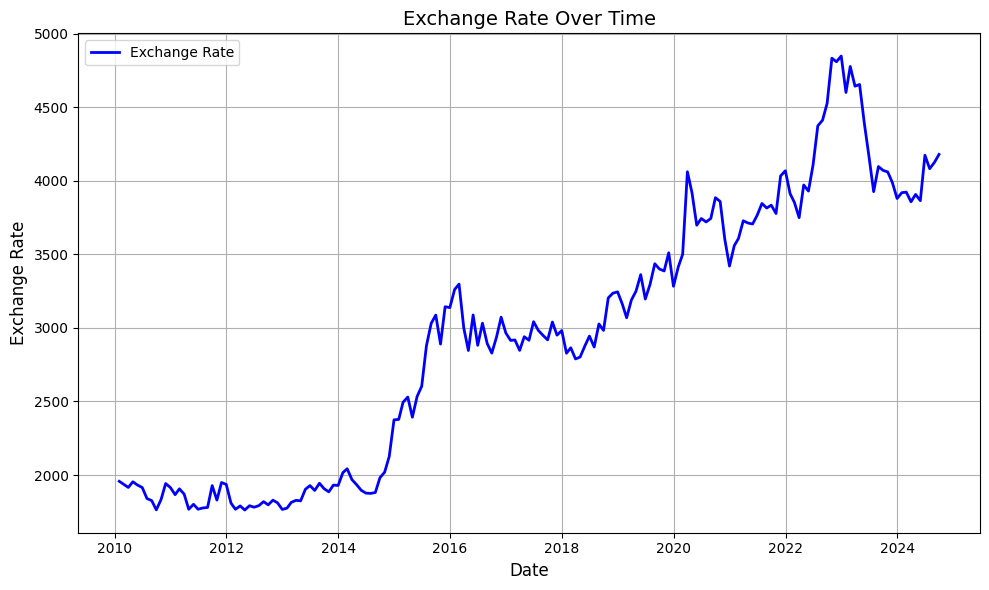

In [13]:
# Ensure the 'Date' column is in datetime format
Monthly_data['Date'] = pd.to_datetime(Monthly_data['Date'])

# Plot the 'Exchange_Rate' column over time
plt.figure(figsize=(10, 6))
plt.plot(Monthly_data['Date'], Monthly_data['Exchange_Rate'], label='Exchange Rate', linewidth=2, color='blue')
plt.title('Exchange Rate Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exchange Rate', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

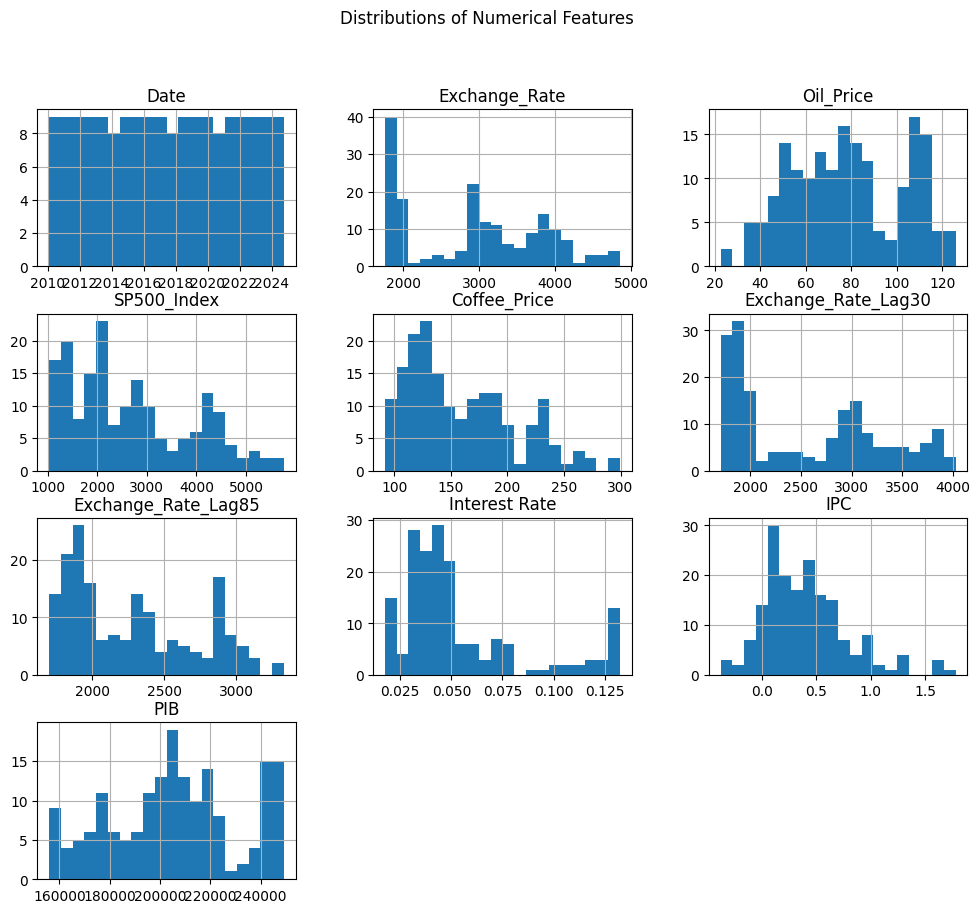

In [14]:
# Plot histograms for each numerical column
Monthly_data.hist(figsize=(12, 10), bins=20)
plt.suptitle('Distributions of Numerical Features')
plt.show()

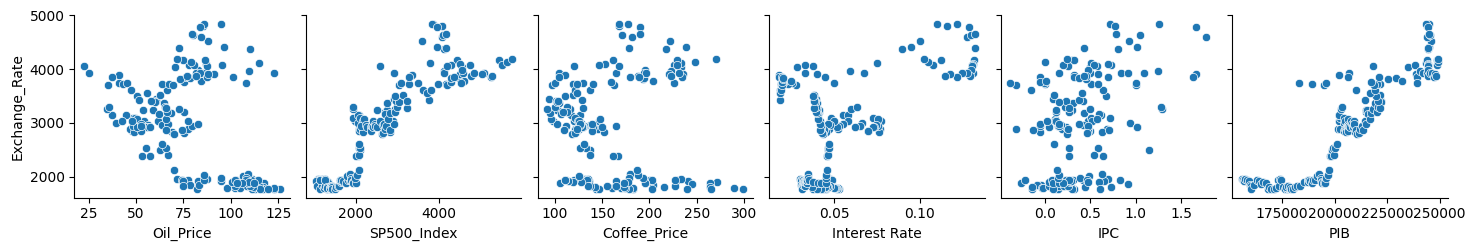

In [15]:
# Pairplots for relationships
sns.pairplot(Monthly_data, y_vars='Exchange_Rate', x_vars=['Oil_Price', 'SP500_Index', 'Coffee_Price', 'Interest Rate', 'IPC', 'PIB'], diag_kind=None)
plt.show()

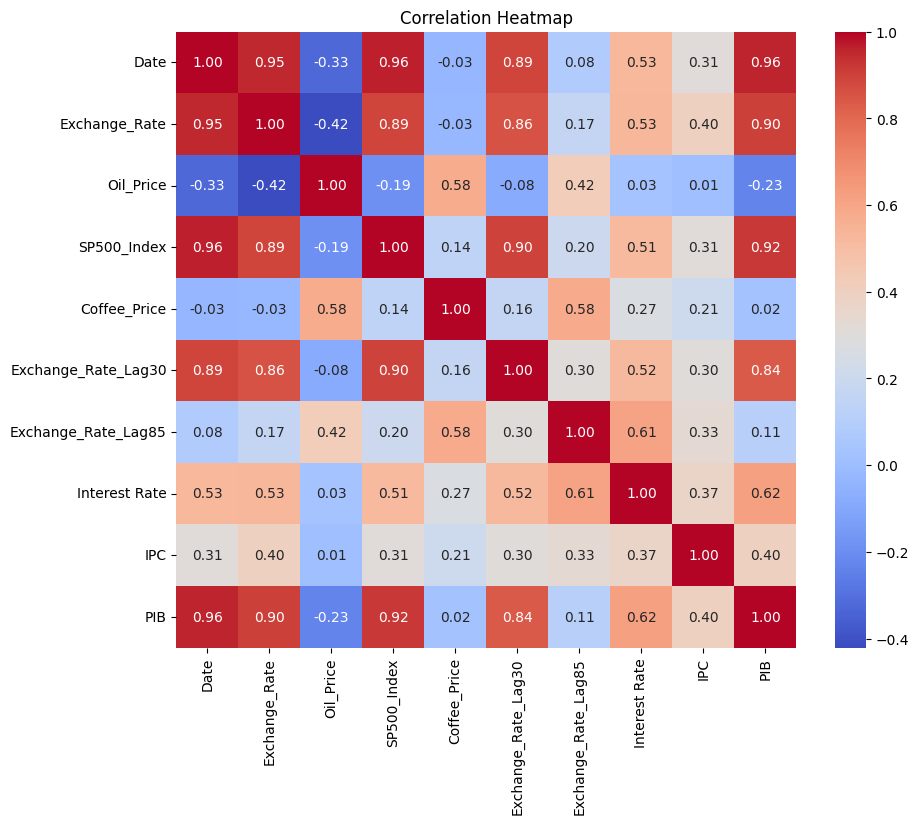

Exchange_Rate          1.000000
Date                   0.950388
PIB                    0.902183
SP500_Index            0.893330
Exchange_Rate_Lag30    0.857808
Interest Rate          0.532816
IPC                    0.400209
Exchange_Rate_Lag85    0.167251
Coffee_Price          -0.026007
Oil_Price             -0.420457
Name: Exchange_Rate, dtype: float64


In [16]:
# Compute the correlation matrix
correlation_matrix = Monthly_data.corr()

# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Display correlations with the target variable
print(correlation_matrix['Exchange_Rate'].sort_values(ascending=False))

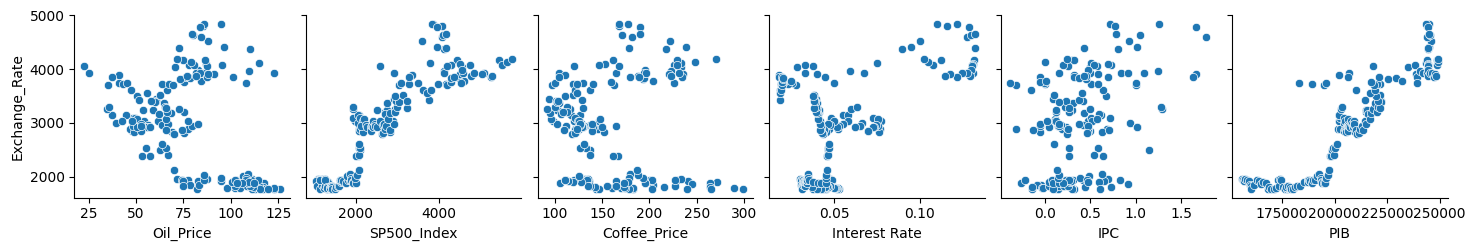

In [17]:
# Pairplots for relationships
sns.pairplot(Monthly_data, y_vars='Exchange_Rate', x_vars=['Oil_Price', 'SP500_Index', 'Coffee_Price', 'Interest Rate', 'IPC', 'PIB'], diag_kind=None)
plt.show()

In [18]:
Monthly_data.columns

Index(['Date', 'Exchange_Rate', 'Oil_Price', 'SP500_Index', 'Coffee_Price',
       'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85', 'Interest Rate', 'IPC',
       'PIB'],
      dtype='object')

In [19]:
# Measure and print the elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time since getting the data: {elapsed_time:.2f} seconds")

Elapsed time since getting the data: 126.16 seconds


In [20]:
#CHECKPOINT (saving processed data)
#Monthly_data = pd.read_csv("D:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project/Monthly_data.csv")
#Monthly_data

## 4. MODELS DEVELOPMENT

#### 4.1 RANDOM FOREST

In [21]:
# Measure training time
start_train_time = time.time()

# Create a new DataFrame from Monthly_data
data_with_index = Monthly_data.copy()

# Add a time index variable
data_with_index['Time_Index'] = range(1, len(data_with_index) + 1)

# Define the target and features
target = 'Exchange_Rate'
features = ['Oil_Price', 'SP500_Index', 'Coffee_Price', 'Exchange_Rate_Lag30',
            'Exchange_Rate_Lag85', 'Interest Rate', 'IPC', 'PIB', 'Time_Index']

# Split the data (80% train, 20% test)
split_index = int(len(data_with_index) * 0.8)
X_train = data_with_index.iloc[:split_index][features]
y_train = data_with_index.iloc[:split_index][target]
X_test = data_with_index.iloc[split_index:][features]
y_test = data_with_index.iloc[split_index:][target]
train_dates = data_with_index.iloc[:split_index]['Date']
test_dates = data_with_index.iloc[split_index:]['Date']
all_dates = data_with_index['Date']


Random Forest - RMSE: 860.37
Random Forest - MAE: 778.03
Random Forest - R²: -5.98
Training Time: 0.5781 seconds
Prediction Time: 0.0173 seconds


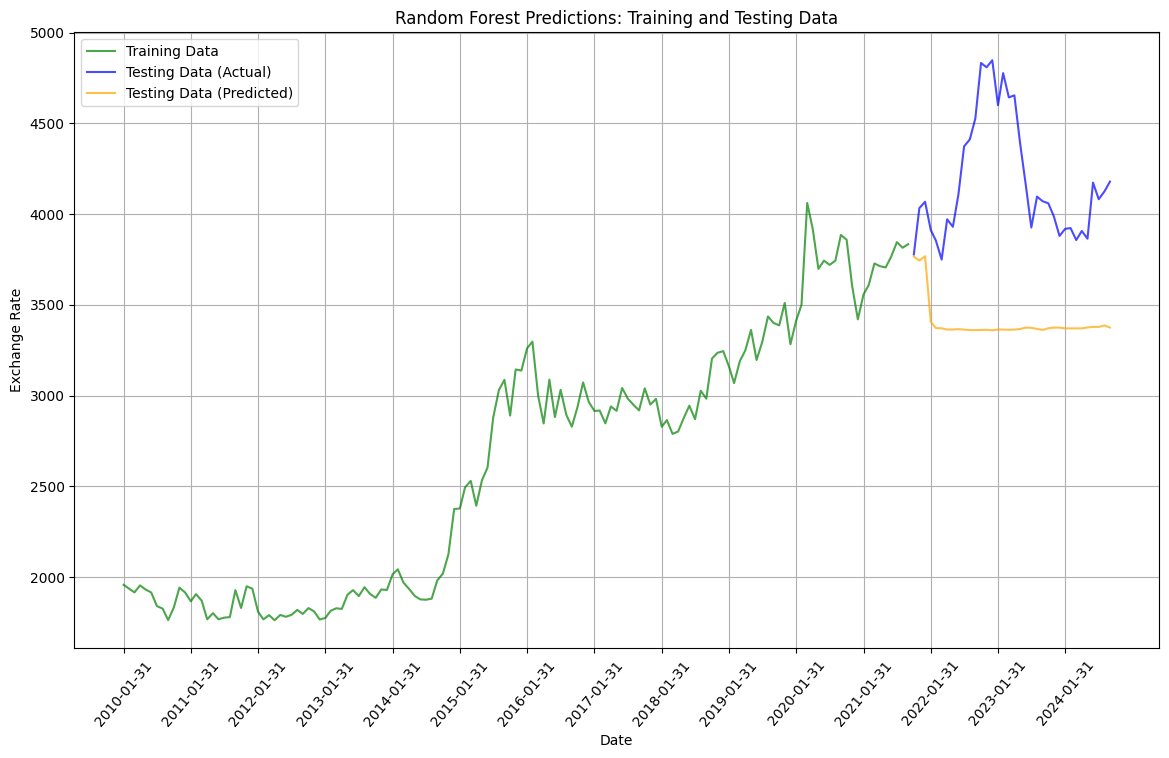

In [22]:
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
end_train_time = time.time()

# Measure prediction time
start_pred_time = time.time()
y_pred_rf = rf_model.predict(X_test)
end_pred_time = time.time()

# Compute evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

# Display metrics
print(f"Random Forest - RMSE: {rmse:.2f}")
print(f"Random Forest - MAE: {mae:.2f}")
print(f"Random Forest - R²: {r2:.2f}")

# Display timing information
train_time = end_train_time - start_train_time
pred_time = end_pred_time - start_pred_time
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {pred_time:.4f} seconds")

# Plot the data
plt.figure(figsize=(14, 8))

# Plot training data in green
plt.plot(train_dates, y_train, label='Training Data', color='green', alpha=0.7)

# Plot testing data (actual) in blue
plt.plot(test_dates, y_test, label='Testing Data (Actual)', color='blue', alpha=0.7)

# Plot testing data (predicted) in orange
plt.plot(test_dates, y_pred_rf, label='Testing Data (Predicted)', color='orange', alpha=0.7)

# Add title and labels
plt.title('Random Forest Predictions: Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)

# Customize x-axis ticks to show fewer labels and rotate them vertically
plt.xticks(all_dates[::12], rotation=50)  # Show one label every 12 months, rotated vertically

# Show plot
plt.show()

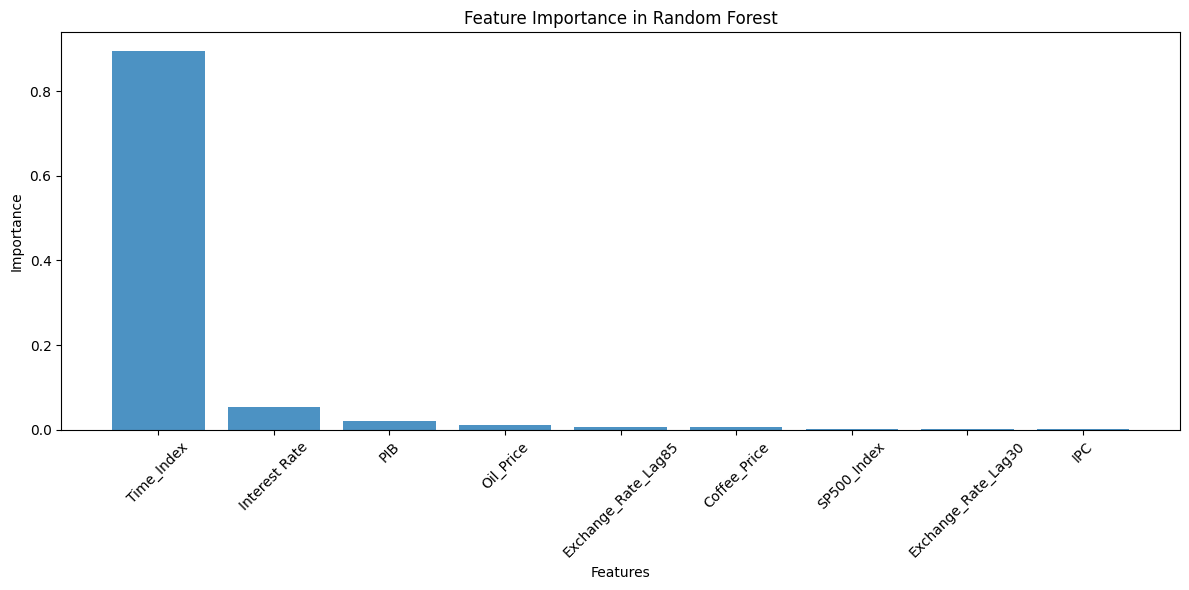

Feature: Time_Index, Importance: 0.8940
Feature: Interest Rate, Importance: 0.0539
Feature: PIB, Importance: 0.0208
Feature: Oil_Price, Importance: 0.0122
Feature: Exchange_Rate_Lag85, Importance: 0.0063
Feature: Coffee_Price, Importance: 0.0057
Feature: SP500_Index, Importance: 0.0032
Feature: Exchange_Rate_Lag30, Importance: 0.0022
Feature: IPC, Importance: 0.0017


In [23]:
# Get feature importance from the Random Forest model
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort the features by importance
sorted_indices = np.argsort(importances)[::-1]

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center', alpha=0.8)
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in sorted_indices], rotation=45)
plt.title("Feature Importance in Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Print feature importance values
for idx in sorted_indices:
    print(f"Feature: {feature_names[idx]}, Importance: {importances[idx]:.4f}")

In [24]:
# Save timing information into a DataFrame
timing_data_df = pd.DataFrame({
    'Model': ['Random Forest'],
    'Training Time (seconds)': [train_time],
    'Prediction Time (seconds)': [pred_time]
})

# Save performance metrics into a DataFrame
performance_data_df = pd.DataFrame({
    'Model': ['Random Forest'],
    'RMSE': [rmse],
    'MAE': [mae],
    'R²': [r2]
})

# Save feature importance into a DataFrame
feature_importance_df = pd.DataFrame({
    'Model': ['Random Forest'] * len(feature_names),  # Repeat model name for all features
    'Feature': [feature_names[i] for i in sorted_indices],  # Feature names sorted by importance
    'Importance': [importances[i] for i in sorted_indices]  # Corresponding importance values
})

# Save predictions into a dataframe
predictions_df = pd.DataFrame({
    'Model': ['Random Forest'] * len(y_pred_rf),  # Model name repeated for all predictions
    'Date': test_dates,  # Dates from the test set
    'Prediction': y_pred_rf  # Predicted values
})

#### 4.2 XGBOOST

Training Time: 0.24 seconds
Prediction Time: 0.01 seconds
XGBoost - RMSE: 1313.17
XGBoost - MAE: 1234.02
XGBoost - R²: -15.26


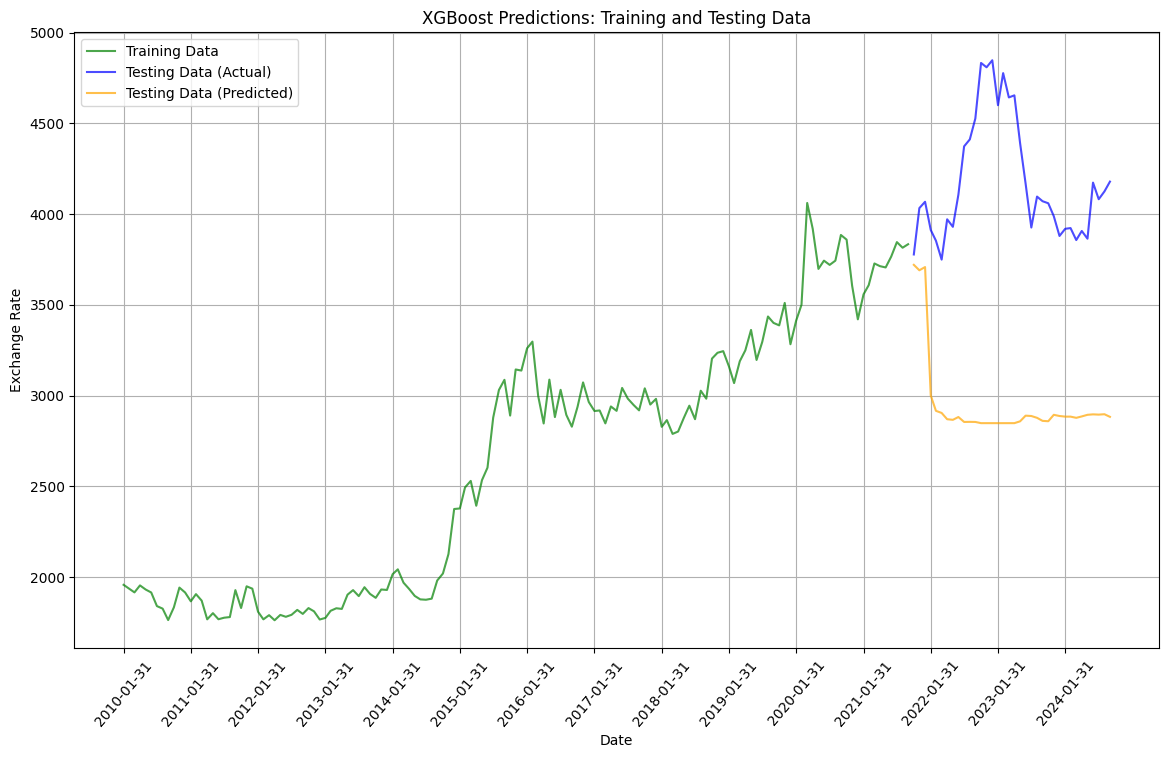

In [25]:
import xgboost as xgb

# Measure time for training
start_train_time = time.time()
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
end_train_time = time.time()
train_time = end_train_time - start_train_time

# Measure time for predictions
start_pred_time = time.time()
y_pred_xgb = xgb_model.predict(X_test)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time

print(f"Training Time: {train_time:.2f} seconds")
print(f"Prediction Time: {pred_time:.2f} seconds")

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae = mean_absolute_error(y_test, y_pred_xgb)
r2 = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - RMSE: {rmse:.2f}")
print(f"XGBoost - MAE: {mae:.2f}")
print(f"XGBoost - R²: {r2:.2f}")

# Plot the data
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(train_dates, y_train, label='Training Data', color='green', alpha=0.7)

# Plot testing data (actual)
plt.plot(test_dates, y_test, label='Testing Data (Actual)', color='blue', alpha=0.7)

# Plot testing data (predicted)
plt.plot(test_dates, y_pred_xgb, label='Testing Data (Predicted)', color='orange', alpha=0.7)

# Add title and labels
plt.title('XGBoost Predictions: Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)

# Customize x-axis labels to show fewer and rotate them vertically
plt.xticks(all_dates[::12], rotation=50)  # Show one label every 12 months, rotated vertically

# Show plot
plt.show()

               Feature  Importance
8           Time_Index    0.951796
5        Interest Rate    0.035919
0            Oil_Price    0.004122
7                  PIB    0.003361
4  Exchange_Rate_Lag85    0.001639
2         Coffee_Price    0.001620
3  Exchange_Rate_Lag30    0.000937
1          SP500_Index    0.000391
6                  IPC    0.000215


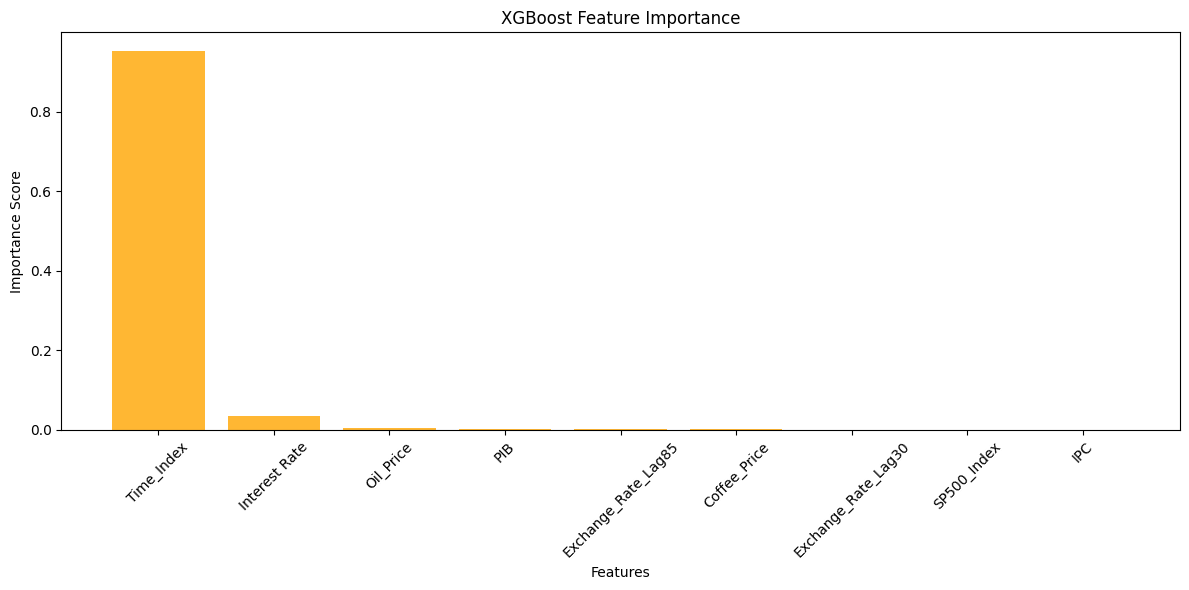

In [26]:
# Get feature importance scores
importance = xgb_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print feature importance values
print(importance_df)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='orange', alpha=0.8)
plt.title('XGBoost Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Timing data for XGBoost
model_timing_data = pd.DataFrame({
    'Model': ['XGBoost'],
    'Training Time (s)': [train_time],
    'Prediction Time (s)': [pred_time]
})
timing_data_df = pd.concat([model_timing_data, timing_data_df], ignore_index=True)

# Performance data for XGBoost
model_performance_data = pd.DataFrame({
    'Model': ['XGBoost'],
    'RMSE': [rmse],
    'MAE': [mae],
    'R²': [r2]
})
performance_data_df = pd.concat([model_performance_data, performance_data_df], ignore_index=True)

# Feature importance data for XGBoost
importances = xgb_model.feature_importances_
feature_importance_data_df = pd.DataFrame({
    'Model': ['XGBoost'] * len(features),
    'Feature': features,
    'Importance': importances
})
feature_importance_df = pd.concat([feature_importance_data_df, feature_importance_df], ignore_index=True)

# Add XGBoost predictions to predictions_df
xgb_predictions_df = pd.DataFrame({
    'Model': ['XGBoost'] * len(y_pred_xgb),
    'Date': test_dates,  # Use the same test dates
    'Prediction': y_pred_xgb
})

# Append to the existing predictions_df
predictions_df = pd.concat([predictions_df, xgb_predictions_df], ignore_index=True)


#### 4.3 LINEAR REGRESSION

Training Time: 0.0461 seconds
Prediction Time: 0.0163 seconds
Linear Regression - RMSE: 410.94
Linear Regression - MAE: 345.63
Linear Regression - R²: -0.59


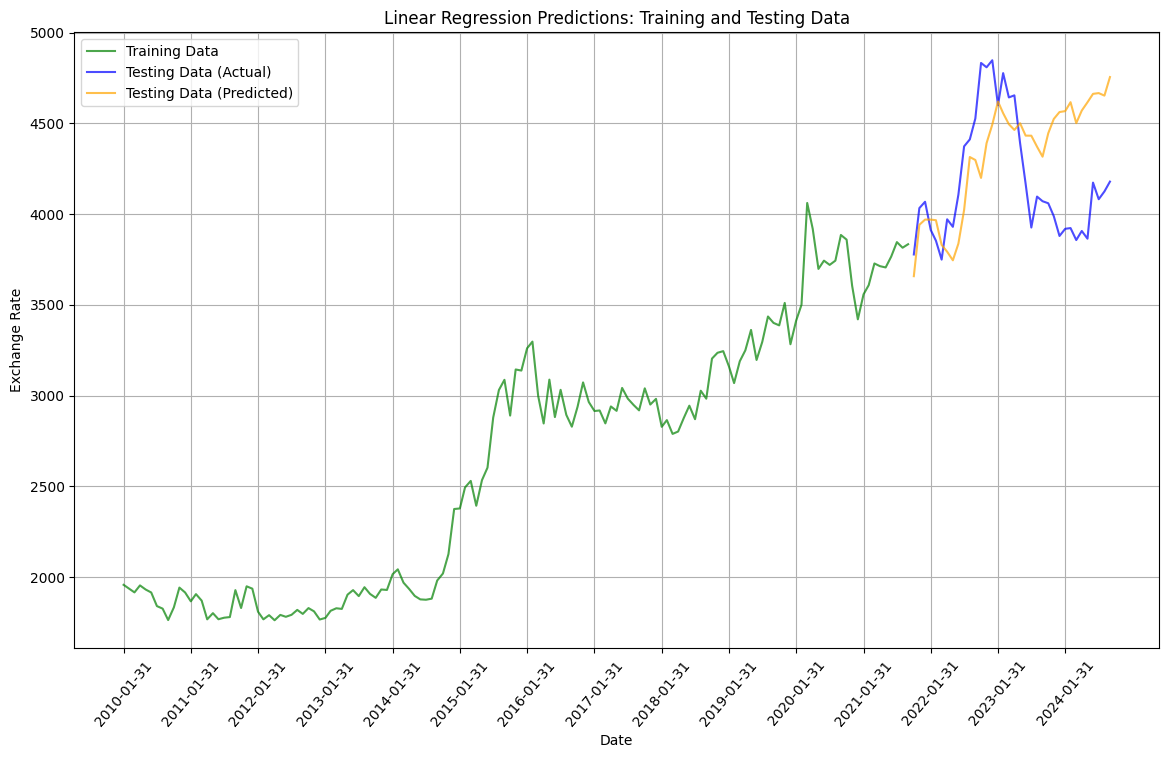

In [28]:
from sklearn.linear_model import LinearRegression

# Measure training time
start_train_time = time.time()

# Define target and features
target = 'Exchange_Rate'
features = ['Oil_Price', 'SP500_Index', 'Coffee_Price', 'Exchange_Rate_Lag30',
            'Exchange_Rate_Lag85', 'Interest Rate', 'IPC', 'PIB', 'Time_Index']

# Split the data into training and testing sets
split_index = int(len(data_with_index) * 0.8)
X_train = data_with_index.iloc[:split_index][features]
y_train = data_with_index.iloc[:split_index][target]
X_test = data_with_index.iloc[split_index:][features]
y_test = data_with_index.iloc[split_index:][target]
train_dates = data_with_index.iloc[:split_index]['Date']
test_dates = data_with_index.iloc[split_index:]['Date']
all_dates = data_with_index['Date']


lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
end_train_time = time.time()

train_time = end_train_time - start_train_time

# Measure prediction time
start_pred_time = time.time()
y_pred_lr = lr_model.predict(X_test)
end_pred_time = time.time()

pred_time = end_pred_time - start_pred_time

print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {pred_time:.4f} seconds")

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mae = mean_absolute_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print(f"Linear Regression - RMSE: {rmse:.2f}")
print(f"Linear Regression - MAE: {mae:.2f}")
print(f"Linear Regression - R²: {r2:.2f}")

# Plot the data
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(train_dates, y_train, label='Training Data', color='green', alpha=0.7)

# Plot testing data (actual)
plt.plot(test_dates, y_test, label='Testing Data (Actual)', color='blue', alpha=0.7)

# Plot testing data (predicted)
plt.plot(test_dates, y_pred_lr, label='Testing Data (Predicted)', color='orange', alpha=0.7)

# Add title and labels
plt.title('Linear Regression Predictions: Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)

# Customize x-axis labels to show fewer and rotate them vertically
plt.xticks(all_dates[::12], rotation=50)  # Show one label every 12 months, rotated vertically

# Show plot
plt.show()

               Feature  Coefficient
5        Interest Rate   297.876372
6                  IPC    97.803484
8           Time_Index    16.266997
0            Oil_Price    -9.104467
2         Coffee_Price     0.845143
4  Exchange_Rate_Lag85     0.401059
3  Exchange_Rate_Lag30     0.086934
1          SP500_Index    -0.013544
7                  PIB    -0.002523


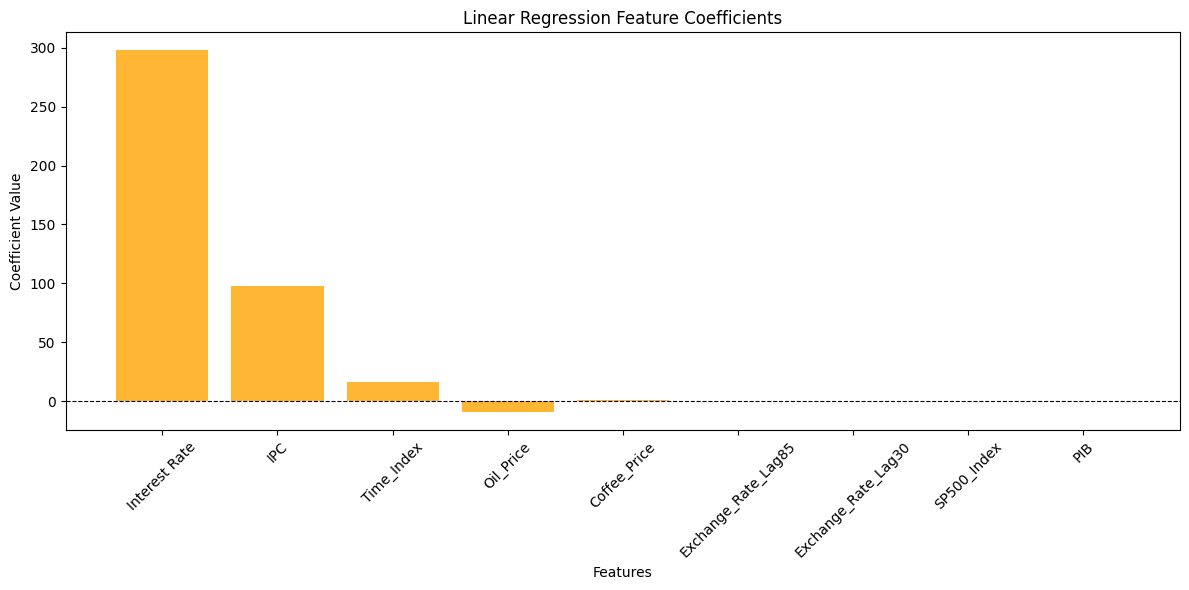

In [29]:
# Retrieve coefficients and feature names
coefficients = lr_model.coef_
feature_names = X_train.columns

# Combine feature names with coefficients into a sorted structure
coef_data = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_data = coef_data.sort_values(by='Coefficient', key=abs, ascending=False)  # Sort by absolute value of coefficients

# Print the coefficients
print(coef_data)

# Plot coefficients
plt.figure(figsize=(12, 6))
plt.bar(coef_data['Feature'], coef_data['Coefficient'], color='orange', alpha=0.8)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Linear Regression Feature Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
# Update timing_data_df
timing_data_df = pd.concat([
    timing_data_df,
    pd.DataFrame({
        'Model': ['Linear Regression'],
        'Training Time (s)': [train_time],
        'Prediction Time (s)': [pred_time]
    })
], ignore_index=True)

# Update performance_data_df
performance_data_df = pd.concat([
    performance_data_df,
    pd.DataFrame({
        'Model': ['Linear Regression'],
        'RMSE': [rmse],
        'MAE': [mae],
        'R²': [r2]
    })
], ignore_index=True)

# Update feature_importance_data_df
feature_importance_df = pd.concat([
    feature_importance_df,
    pd.DataFrame({
        'Model': ['Linear Regression'] * len(features),
        'Feature': features,
        'Importance': lr_model.coef_  # Coefficients as importance
    })
], ignore_index=True)

# Update predictions_df
lr_predictions_df = pd.DataFrame({
    'Model': ['Linear Regression'] * len(y_pred_lr),
    'Date': test_dates,
    'Prediction': y_pred_lr
})

predictions_df = pd.concat([predictions_df, lr_predictions_df], ignore_index=True)

TRANSFORMING DATA FOR MODELING

In [31]:
# Split data based on time (80% train, 20% test)
split_index = int(len(Monthly_data) * 0.8)
train_data = Monthly_data.iloc[:split_index].copy()  # Create a copy to avoid SettingWithCopyWarning
test_data = Monthly_data.iloc[split_index:].copy()

# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Transform the training set
train_data[['Interest Rate', 'IPC']] = minmax_scaler.fit_transform(train_data[['Interest Rate', 'IPC']])
train_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'PIB', 'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']] = standard_scaler.fit_transform(
    train_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'PIB', 'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']]
)

# Apply the same transformations to the test set using parameters from the training set
test_data[['Interest Rate', 'IPC']] = minmax_scaler.transform(test_data[['Interest Rate', 'IPC']])
test_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'PIB', 'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']] = standard_scaler.transform(
    test_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'PIB', 'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']]
)

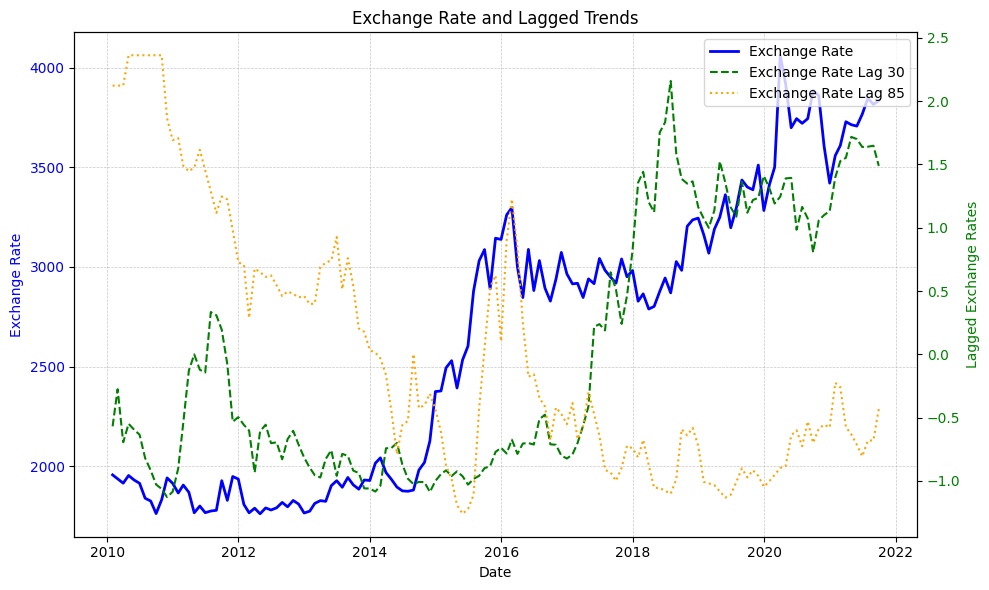

In [32]:
import matplotlib.pyplot as plt

# Create the main plot
fig, ax1 = plt.subplots(figsize=(10, 6))  # Adjust the size of the figure if needed

# Plot the first variable on the primary y-axis
ax1.plot(train_data['Date'], train_data['Exchange_Rate'], label='Exchange Rate', color='blue', linewidth=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Exchange Rate', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add a grid to the primary y-axis
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the other variables on the secondary y-axis
ax2.plot(train_data['Date'], train_data['Exchange_Rate_Lag30'], label='Exchange Rate Lag 30', color='green', linestyle='--')
ax2.plot(train_data['Date'], train_data['Exchange_Rate_Lag85'], label='Exchange Rate Lag 85', color='orange', linestyle=':')
ax2.set_ylabel('Lagged Exchange Rates', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a legend
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a title
plt.title('Exchange Rate and Lagged Trends')

# Adjust layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()

In [33]:
#SPLITTING DATA INTO TRAIN AND TEST

# Define features and target
X_train = train_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'Interest Rate', 'IPC', 'PIB', 
                      'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']]
y_train = train_data['Exchange_Rate']
X_test = test_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'Interest Rate', 'IPC', 'PIB', 
                    'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']]
y_test = test_data['Exchange_Rate']

#### 4.4 PROPHET Algorithm

15:39:15 - cmdstanpy - INFO - Chain [1] start processing
15:39:16 - cmdstanpy - INFO - Chain [1] done processing
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


Prophet - RMSE: 393.42
Prophet - MAE: 323.20
Prophet - R²: -0.46
Training Time: 1.9869 seconds
Prediction Time: 0.1984 seconds


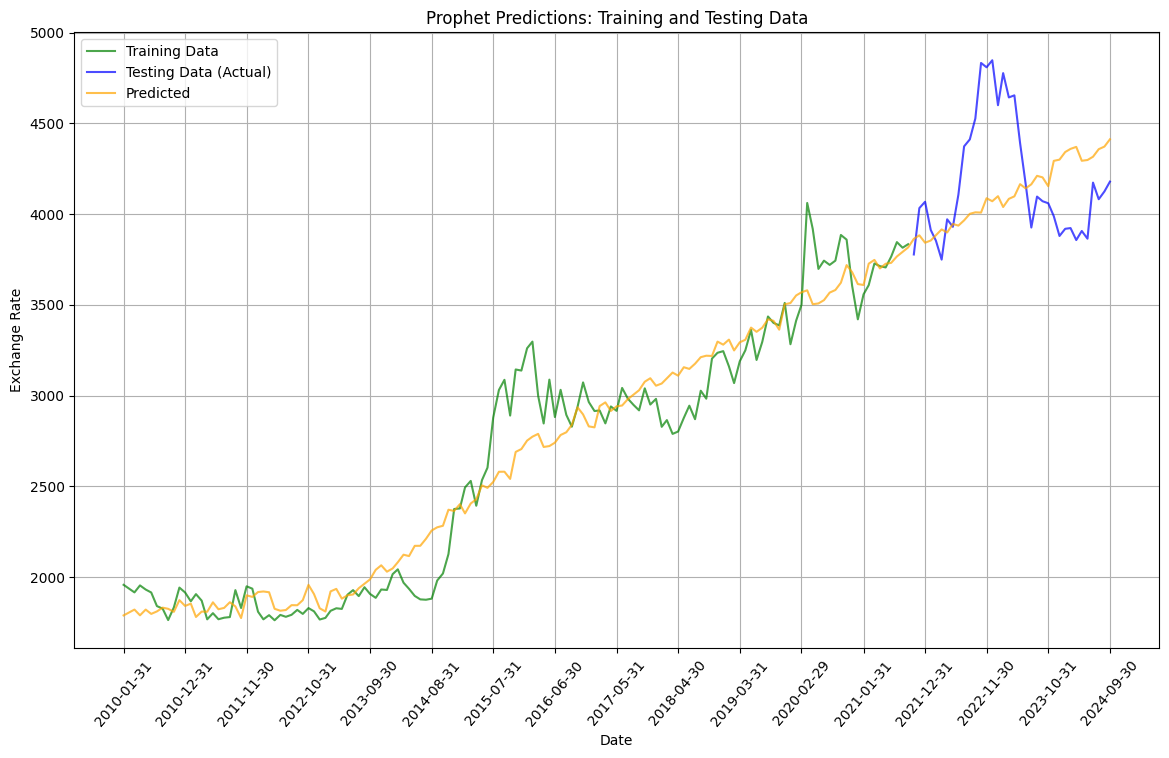

In [34]:
# Measure training time
start_train_time = time.time()

# Prepare data for Prophet
prophet_train = train_data[['Date', 'Exchange_Rate']].rename(columns={'Date': 'ds', 'Exchange_Rate': 'y'})
prophet_test = test_data[['Date', 'Exchange_Rate']].rename(columns={'Date': 'ds', 'Exchange_Rate': 'y'})

# Ensure 'ds' columns are datetime and numeric values are float
prophet_train['ds'] = pd.to_datetime(prophet_train['ds'])
prophet_test['ds'] = pd.to_datetime(prophet_test['ds'])

prophet_train['y'] = pd.to_numeric(prophet_train['y'], errors='coerce')
prophet_test['y'] = pd.to_numeric(prophet_test['y'], errors='coerce')

prophet_model = Prophet()
prophet_model.fit(prophet_train)
end_train_time = time.time()
train_time = end_train_time - start_train_time

# Measure prediction time
future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='M')
start_pred_time = time.time()
forecast = prophet_model.predict(future)
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time

# Extract predictions for the test set period
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['yhat'] = pd.to_numeric(forecast['yhat'], errors='coerce')
prophet_predictions = forecast[['ds', 'yhat']].merge(prophet_test, on='ds', how='right')

# Compute performance metrics
prophet_rmse = np.sqrt(mean_squared_error(prophet_predictions['y'], prophet_predictions['yhat']))
prophet_mae = mean_absolute_error(prophet_predictions['y'], prophet_predictions['yhat'])
prophet_r2 = r2_score(prophet_predictions['y'], prophet_predictions['yhat'])

# Display metrics and timing
print(f"Prophet - RMSE: {prophet_rmse:.2f}")
print(f"Prophet - MAE: {prophet_mae:.2f}")
print(f"Prophet - R²: {prophet_r2:.2f}")
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {pred_time:.4f} seconds")

# Combine all dates for consistent x-axis
all_dates = np.concatenate([prophet_train['ds'], prophet_test['ds']])

# Plot the entire dataset: training, testing, and predictions
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(prophet_train['ds'], prophet_train['y'], label='Training Data', color='green', alpha=0.7)

# Plot testing data
plt.plot(prophet_test['ds'], prophet_test['y'], label='Testing Data (Actual)', color='blue', alpha=0.7)

# Plot predictions (including training and testing periods)
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted', color='orange', alpha=0.7)

# Add title and labels
plt.title('Prophet Predictions: Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)

# Customize x-axis labels to match ARIMA format
tick_spacing = len(all_dates) // 15  # Adjust the divisor to control label density
plt.xticks(
    ticks=all_dates[::tick_spacing],
    labels=pd.to_datetime(all_dates[::tick_spacing]).strftime('%Y-%m-%d'),
    rotation=50
)

# Show the plot
plt.show()

In [35]:
# Update timing_data_df
timing_data_df = pd.concat([
    timing_data_df,
    pd.DataFrame({
        'Model': ['Prophet'],
        'Training Time (s)': [train_time],
        'Prediction Time (s)': [pred_time]
    })
], ignore_index=True)

# Update performance_data_df
performance_data_df = pd.concat([
    performance_data_df,
    pd.DataFrame({
        'Model': ['Prophet'],
        'RMSE': [prophet_rmse],
        'MAE': [prophet_mae],
        'R²': [prophet_r2]
    })
], ignore_index=True)

# Prophet does not involve features, so feature_importance_data_df is not updated.

# Update predictions_df
prophet_predictions_df = pd.DataFrame({
    'Model': ['Prophet'] * len(prophet_predictions),
    'Date': prophet_predictions['ds'],
    'Prediction': prophet_predictions['yhat']
})
predictions_df = pd.concat([predictions_df, prophet_predictions_df], ignore_index=True)

# Display updated dataframes for verification
print("Updated timing_data_df:")

print("\nUpdated performance_data_df:")

print("\nUpdated predictions_df:")

Updated timing_data_df:

Updated performance_data_df:

Updated predictions_df:


#### 4.5 ARIMA

In [ ]:
# Measure training time
start_train_time = time.time()

#Check Stationarity
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(train_data['Exchange_Rate'])

# Extract results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value {key}: {value}")

# Interpretation
if result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is not stationary. Differencing is required.")

ADF Statistic: -0.35508333849459506
p-value: 0.917332464859526
Critical Value 1%: -3.480118600110386
Critical Value 5%: -2.8833618426136196
Critical Value 10%: -2.578407034974382
The series is not stationary. Differencing is required.


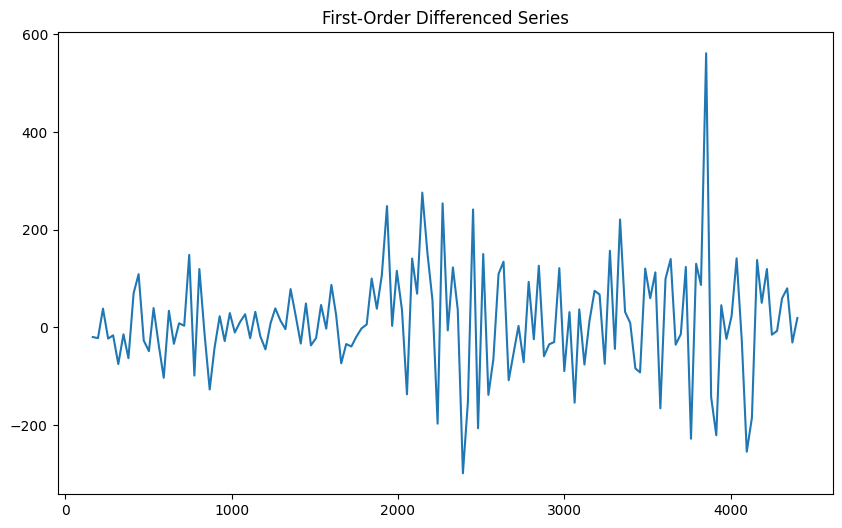

In [37]:
#Differencing

# First differencing
train_data_diff = train_data['Exchange_Rate'].diff().dropna()

# Plot differenced series
plt.figure(figsize=(10, 6))
plt.plot(train_data_diff)
plt.title("First-Order Differenced Series")
plt.show()

In [38]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on the differenced series
adf_test_result = adfuller(train_data_diff)

# Extract and print the results
print("ADF Statistic:", adf_test_result[0])
print("p-value:", adf_test_result[1])
print("Critical Values:")
for key, value in adf_test_result[4].items():
    print(f"   {key}: {value}")

# Interpretation
if adf_test_result[1] <= 0.05:
    print("The series is stationary (reject the null hypothesis of a unit root).")
else:
    print("The series is not stationary (fail to reject the null hypothesis).")

ADF Statistic: -4.1344681988500875
p-value: 0.0008489822851344712
Critical Values:
   1%: -3.480118600110386
   5%: -2.8833618426136196
   10%: -2.578407034974382
The series is stationary (reject the null hypothesis of a unit root).


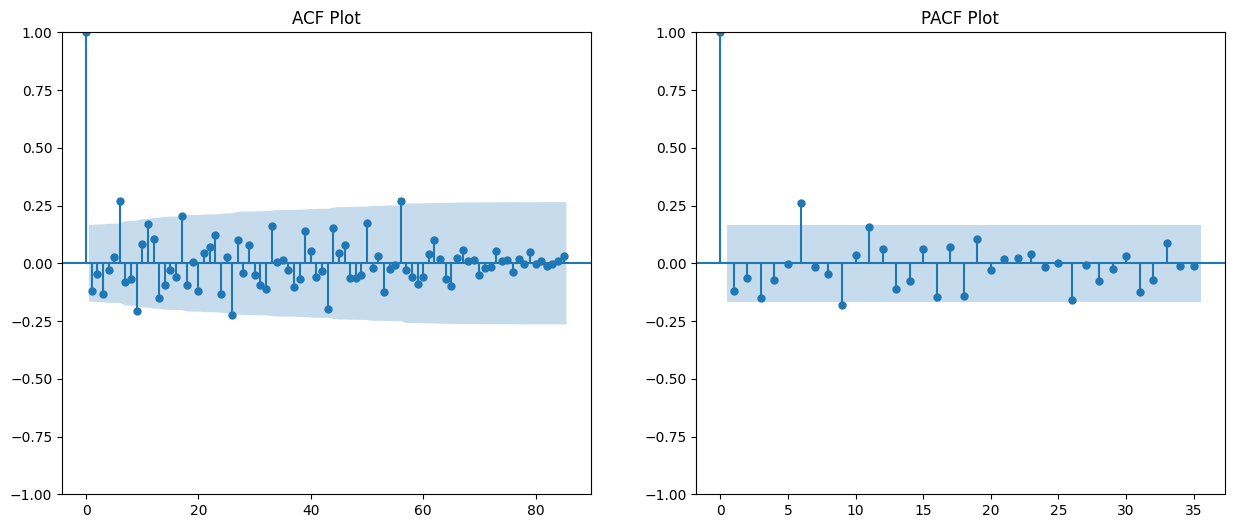

In [39]:
#Identify ARIMA Order (p, d, q)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

plot_acf(train_data_diff, lags=85, ax=axes[0])  # ACF PlOT: Helps identify Q (MA order) Shows the correlation between the time series and its lagged values
axes[0].set_title("ACF Plot")

plot_pacf(train_data_diff, lags=35, ax=axes[1])  # PACF (Partial Autocorrelation Function) Helps identify P (AR order) Shows the correlation between the time series and its lagged values, removing the influence of intermediate lags
axes[1].set_title("PACF Plot")

plt.show()


In [40]:
# Convert the 'Date' column to a datetime index if not already done
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data.set_index('Date', inplace=True)

test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data.set_index('Date', inplace=True)

In [41]:
from statsmodels.tsa.arima.model import ARIMA

# Define ARIMA configurations
#arima_orders,  P IDENTIFIED: 1, 7, 10 Q VALUES: 1, 7, 10, 27, 57. (1, 1, 7), (7, 1, 27), (1, 1, 27), 
arima_orders = [(1, 1, 1), (1, 1, 10), (1, 1, 57),(7, 1, 1), (7, 1, 7), (7, 1, 10), (7, 1, 57), (10, 1, 1), (10, 1, 7), (10, 1, 10), (10, 1, 27), (10, 1, 57)]

# Store results for comparison
results = []

for order in arima_orders:
    # Fit the ARIMA model
    arima_model = ARIMA(train_data['Exchange_Rate'], order=order)
    arima_result = arima_model.fit()

    # Forecast test set
    y_pred_arima = arima_result.forecast(steps=len(test_data))

    # Compute performance metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred_arima))
    mae = mean_absolute_error(y_test, y_pred_arima)
    r2 = r2_score(y_test, y_pred_arima)
    aic = arima_result.aic

    # Append results
    results.append({
        'Order': order,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2,
        'AIC': aic
    })

    # Print summary for the current model
    print(f"Model ARIMA{order} fitted successfully.")

d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_proje

Model ARIMA(1, 1, 1) fitted successfully.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\

Model ARIMA(1, 1, 10) fitted successfully.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model ARIMA(1, 1, 57) fitted successfully.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Model ARIMA(7, 1, 1) fitted successfully.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Desktop\PORTFOLIO PROJECT\

Model ARIMA(7, 1, 7) fitted successfully.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\

Model ARIMA(7, 1, 10) fitted successfully.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model ARIMA(7, 1, 57) fitted successfully.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Model ARIMA(10, 1, 1) fitted successfully.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Desktop\PORTFOLIO PROJECT\

Model ARIMA(10, 1, 7) fitted successfully.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\

Model ARIMA(10, 1, 10) fitted successfully.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model ARIMA(10, 1, 27) fitted successfully.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observat

Model ARIMA(10, 1, 57) fitted successfully.


In [ ]:
#Compare Results

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
results_df = results_df.sort_values('RMSE')  # Sort by RMSE for comparison
print(results_df)

          Order        RMSE         MAE        R²          AIC
10  (10, 1, 27)  464.750256  342.008484 -1.036521  1743.565925
3     (7, 1, 1)  469.396048  346.509068 -1.077440  1720.658777
0     (1, 1, 1)  480.217552  360.066312 -1.174331  1721.861665
1    (1, 1, 10)  495.156719  378.669243 -1.311719  1718.883250
4     (7, 1, 7)  496.725806  372.413615 -1.326393  1719.193156
2    (1, 1, 57)  498.301706  364.423181 -1.341178  1772.655787
6    (7, 1, 57)  502.468010  368.998153 -1.380490  1780.194743
7    (10, 1, 1)  503.495037  388.067033 -1.390232  1719.946987
11  (10, 1, 57)  509.929597  377.061878 -1.451715  1785.581608
5    (7, 1, 10)  522.795143  406.551252 -1.576990  1726.012774
8    (10, 1, 7)  527.090250  407.960940 -1.619507  1723.803381
9   (10, 1, 10)  535.140673  420.529442 -1.700135  1729.727315


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Desktop\PORTFOLIO

ARIMA(10, 1, 27) - RMSE: 464.75
ARIMA(10, 1, 27) - MAE: 342.01
ARIMA(10, 1, 27) - R²: -1.04
Training Time: 277.8446 seconds
Prediction Time: 0.0153 seconds


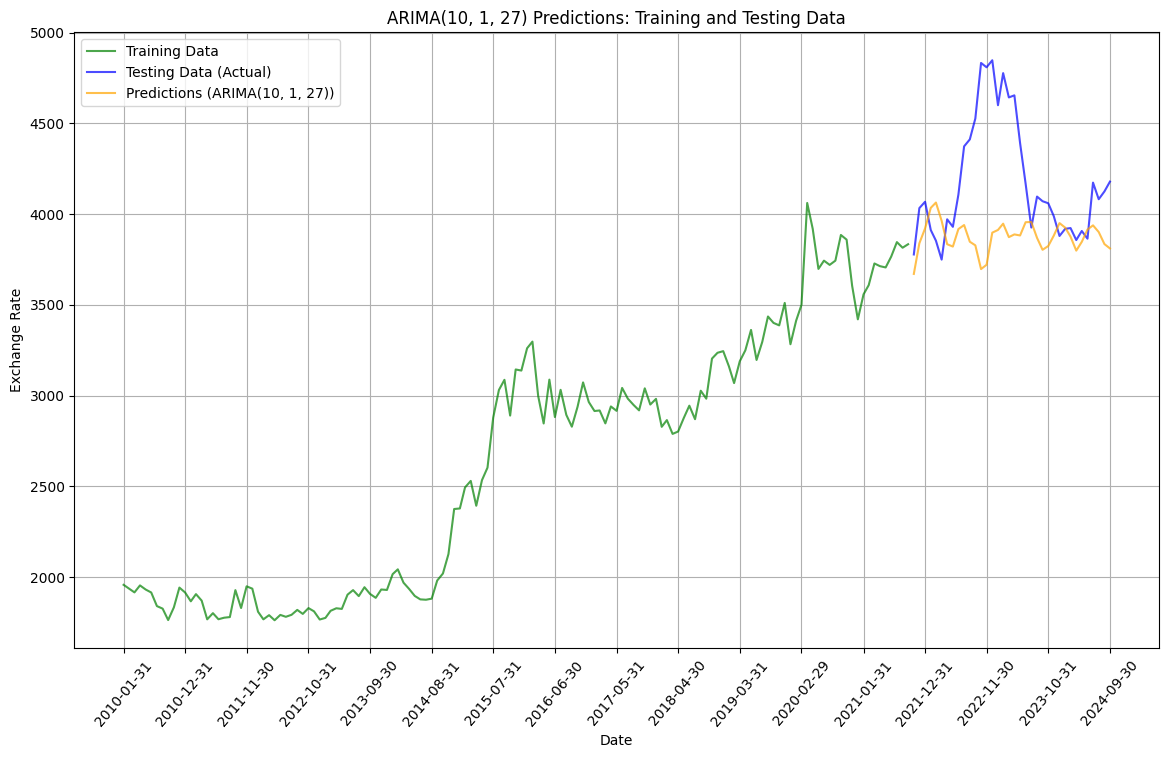

In [43]:
#Plot Predictions for the Best Model

from statsmodels.tsa.arima.model import ARIMA

# Add the 'Date' column back to train_data and test_data
train_data['Date'] = Monthly_data.iloc[:split_index]['Date'].values
test_data['Date'] = Monthly_data.iloc[split_index:]['Date'].values

# Choose the best model based on RMSE
best_model_order = results_df.iloc[0]['Order']


best_arima_model = ARIMA(train_data['Exchange_Rate'], order=best_model_order)
best_arima_result = best_arima_model.fit()
end_train_time = time.time()
train_time = end_train_time - start_train_time

# Measure prediction time
start_pred_time = time.time()
y_pred_best = best_arima_result.forecast(steps=len(test_data))
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# Display metrics and timing
print(f"ARIMA{best_model_order} - RMSE: {rmse:.2f}")
print(f"ARIMA{best_model_order} - MAE: {mae:.2f}")
print(f"ARIMA{best_model_order} - R²: {r2:.2f}")
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {pred_time:.4f} seconds")

# Plot training, testing, and predictions
plt.figure(figsize=(14, 8))

# Training data
plt.plot(train_data['Date'], train_data['Exchange_Rate'], label='Training Data', color='green', alpha=0.7)

# Testing data (actual)
plt.plot(test_data['Date'], y_test, label='Testing Data (Actual)', color='blue', alpha=0.7)

# Testing data (predicted)
plt.plot(test_data['Date'], y_pred_best, label=f'Predictions (ARIMA{best_model_order})', color='orange', alpha=0.7)

# Customize the plot
plt.title(f'ARIMA{best_model_order} Predictions: Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)

# Customize x-axis labels
all_dates = np.concatenate([train_data['Date'], test_data['Date']])
tick_spacing = len(all_dates) // 15
plt.xticks(
    ticks=all_dates[::tick_spacing],
    labels=pd.to_datetime(all_dates[::tick_spacing]).strftime('%Y-%m-%d'),
    rotation=50
)

plt.show()

In [44]:

# Update timing_data_df
timing_data_df = pd.concat([
    timing_data_df,
    pd.DataFrame({
        'Model': [f'ARIMA{best_model_order}'],
        'Training Time (s)': [train_time],
        'Prediction Time (s)': [pred_time]
    })
], ignore_index=True)

# Update performance_data_df
performance_data_df = pd.concat([
    performance_data_df,
    pd.DataFrame({
        'Model': [f'ARIMA{best_model_order}'],
        'RMSE': [rmse],
        'MAE': [mae],
        'R²': [r2]
    })
], ignore_index=True)

# Update predictions_df
predictions_df = pd.concat([
    predictions_df,
    pd.DataFrame({
        'Model': [f'ARIMA{best_model_order}'] * len(test_data),
        'Date': test_data['Date'],
        'Prediction': y_pred_best
    })
], ignore_index=True)

#### 4.6 SARIMA

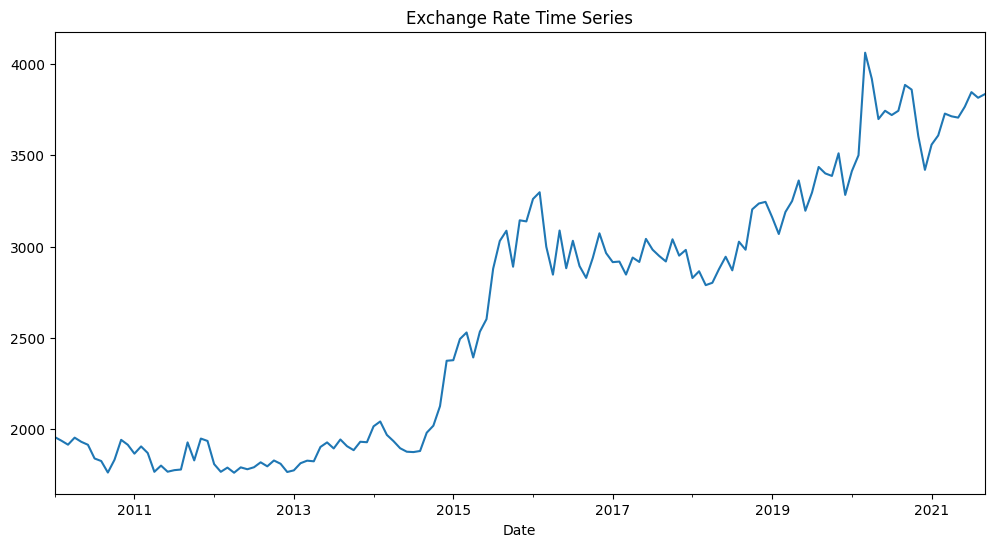

In [45]:
# Measure training time
start_train_time = time.time()

train_data['Exchange_Rate'].plot(figsize=(12, 6))
plt.title('Exchange Rate Time Series')
plt.show()

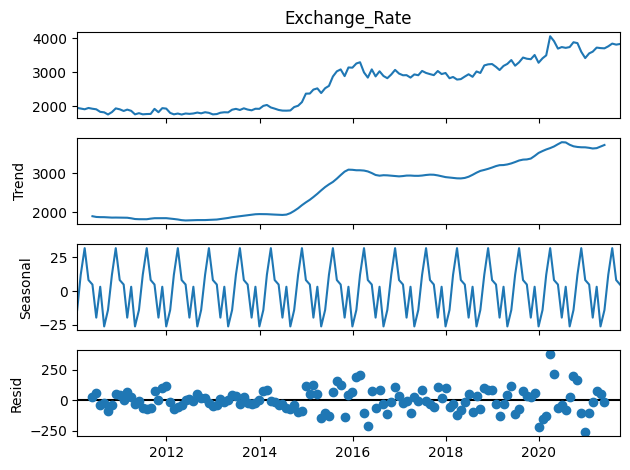

In [46]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(train_data['Exchange_Rate'], period=8) 
decomposition.plot()
plt.show()


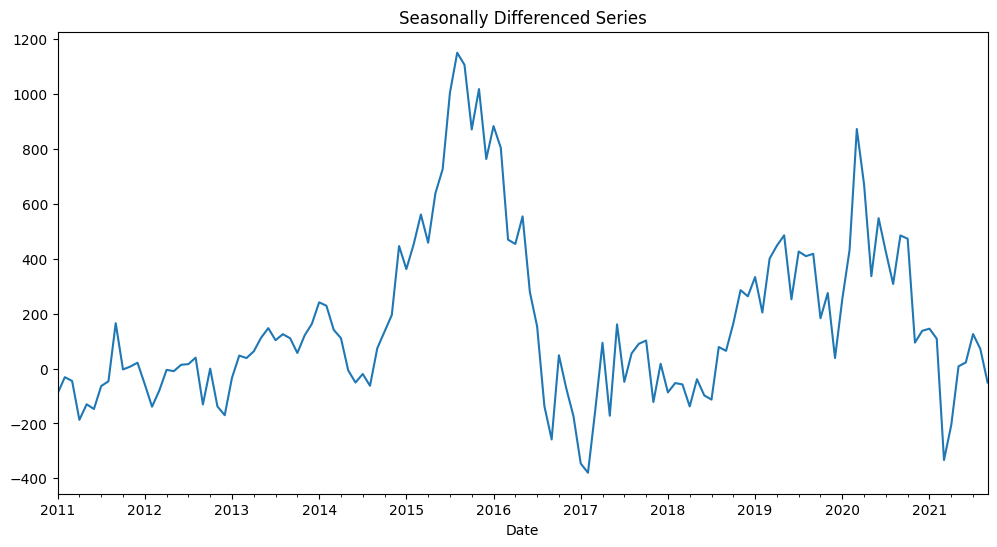

In [47]:
#If the seasonal pattern is evident, apply seasonal differencing to make the data stationary
train_data['Exchange_Rate_diff'] = train_data['Exchange_Rate'].diff(12)  
train_data['Exchange_Rate_diff'].dropna().plot(figsize=(12, 6))
plt.title('Seasonally Differenced Series')
plt.show()

In [48]:
from statsmodels.tsa.stattools import adfuller

# Seasonally differenced series
seasonally_differenced_series = train_data['Exchange_Rate_diff'].dropna()

# Perform ADF test
adf_test_result = adfuller(seasonally_differenced_series)

# Extract and print the results
print("ADF Statistic:", adf_test_result[0])
print("p-value:", adf_test_result[1])
print("Critical Values:")
for key, value in adf_test_result[4].items():
    print(f"\t{key}: {value}")

# Interpretation
if adf_test_result[1] <= 0.05:
    print("The series is stationary (reject the null hypothesis).")
else:
    print("The series is not stationary (fail to reject the null hypothesis).")

ADF Statistic: -2.2464363577731845
p-value: 0.18982524083812718
Critical Values:
	1%: -3.4885349695076844
	5%: -2.887019521656941
	10%: -2.5803597920604915
The series is not stationary (fail to reject the null hypothesis).


In [ ]:
train_data['Exchange_Rate_diff2'] = train_data['Exchange_Rate_diff'].diff()

result = adfuller(train_data['Exchange_Rate_diff2'].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("Data is stationary")
else:
    print("Data is not stationary")

ADF Statistic: -4.44721563333174
p-value: 0.0002446438993512747
Data is stationary


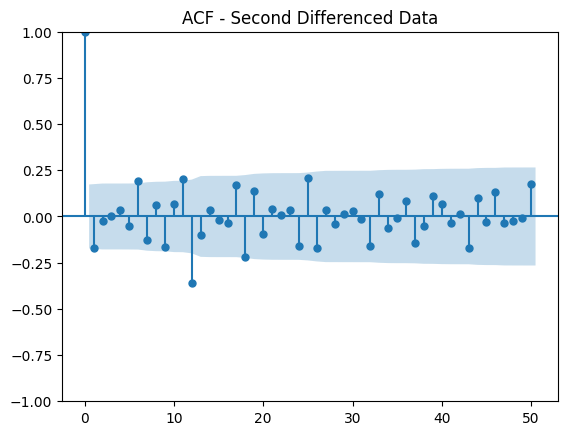

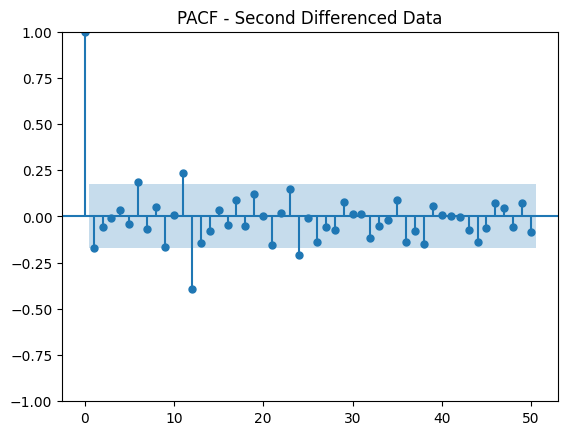

In [50]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(train_data['Exchange_Rate_diff2'].dropna(), lags=50)
plt.title('ACF - Second Differenced Data')
plt.show()

plot_pacf(train_data['Exchange_Rate_diff2'].dropna(), lags=50)
plt.title('PACF - Second Differenced Data')
plt.show()

In [51]:
from itertools import product
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import time

# Define parameter ranges
p_values = [1, 7, 12, 13, 25, 85]
q_values = [1, 7, 13]
P_values = [1, 2, 3]
Q_values = [1, 2]
d = 1
D = 2
s = 12

# Prepare to store results
results = []

# Generate all combinations of parameters
param_combinations = list(product(p_values, q_values, P_values, Q_values))

# Loop through each combination
for p, q, P, Q in param_combinations:
    try:
        # Define SARIMA parameters
        order = (p, d, q)  # Non-seasonal
        seasonal_order = (P, D, Q, s)  # Seasonal
        
        # Measure training time
        start_train_time = time.time()
        sarima_model = SARIMAX(
            train_data['Exchange_Rate'],
            order=order,
            seasonal_order=seasonal_order
        )
        sarima_result = sarima_model.fit(disp=False)
        end_train_time = time.time()
        train_time = end_train_time - start_train_time

        # Measure prediction time
        start_pred_time = time.time()
        y_pred_sarima = sarima_result.forecast(steps=len(test_data))
        end_pred_time = time.time()
        pred_time = end_pred_time - start_pred_time

        # Evaluate performance
        rmse = np.sqrt(mean_squared_error(y_test, y_pred_sarima))
        mae = mean_absolute_error(y_test, y_pred_sarima)
        r2 = r2_score(y_test, y_pred_sarima)

        # Store the results
        results.append({
            'p': p, 'q': q, 'P': P, 'Q': Q,
            'RMSE': rmse, 'MAE': mae, 'R2': r2,
            'Train Time': train_time, 'Prediction Time': pred_time
        })
        print(f"Combination (p={p}, q={q}, P={P}, Q={Q}) succeeded.")
    except Exception as e:
        print(f"Combination (p={p}, q={q}, P={P}, Q={Q}) failed: {e}")


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\

Combination (p=1, q=1, P=1, Q=1) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Combination (p=1, q=1, P=1, Q=2) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Combination (p=1, q=1, P=2, Q=1) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Combination (p=1, q=1, P=2, Q=2) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=1, q=1, P=3, Q=1) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Combination (p=1, q=1, P=3, Q=2) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=1, q=7, P=1, Q=1) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed

Combination (p=1, q=7, P=1, Q=2) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=1, q=7, P=2, Q=1) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


Combination (p=1, q=7, P=2, Q=2) failed: LU decomposition error.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=1, q=7, P=3, Q=1) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=1, q=7, P=3, Q=2) succeeded.
Combination (p=1, q=13, P=1, Q=1) failed: Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Combination (p=1, q=13, P=1, Q=2) failed: Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Combination (p=1, q=13, P=2, Q=1) failed: Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Combination (p=1, q=13, P=2, Q=2) failed: Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Combination (p=1, q=13, P=3, Q=1) failed: Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Combination (p=1, q=13, P=3, Q=2) failed: Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal movin

d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=7, q=1, P=1, Q=1) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed

Combination (p=7, q=1, P=1, Q=2) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=7, q=1, P=2, Q=1) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=7, q=1, P=2, Q=2) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=7, q=1, P=3, Q=1) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=7, q=1, P=3, Q=2) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=7, q=7, P=1, Q=1) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed

Combination (p=7, q=7, P=1, Q=2) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=7, q=7, P=2, Q=1) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=7, q=7, P=2, Q=2) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=7, q=7, P=3, Q=1) succeeded.


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Combination (p=7, q=7, P=3, Q=2) succeeded.
Combination (p=7, q=13, P=1, Q=1) failed: Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Combination (p=7, q=13, P=1, Q=2) failed: Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Combination (p=7, q=13, P=2, Q=1) failed: Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Combination (p=7, q=13, P=2, Q=2) failed: Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Combination (p=7, q=13, P=3, Q=1) failed: Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal moving average components.
Combination (p=7, q=13, P=3, Q=2) failed: Invalid model: moving average lag(s) {np.int64(12)} are in both the seasonal and non-seasonal movin

In [ ]:
# Sort the DataFrame by MAE in ascending order
results_df.sort_values(by='MAE', ascending=True, inplace=True)

# Display the sorted DataFrame
from IPython.display import display
display(results_df)

,Order,RMSE,MAE,R²,AIC
10,"(10, 1, 27)",464.750256,342.008484,-1.036521,1743.565925
3,"(7, 1, 1)",469.396048,346.509068,-1.077440,1720.658777
0,"(1, 1, 1)",480.217552,360.066312,-1.174331,1721.861665
2,"(1, 1, 57)",498.301706,364.423181,-1.341178,1772.655787
6,"(7, 1, 57)",502.468010,368.998153,-1.380490,1780.194743
4,"(7, 1, 7)",496.725806,372.413615,-1.326393,1719.193156
11,"(10, 1, 57)",509.929597,377.061878,-1.451715,1785.581608
1,"(1, 1, 10)",495.156719,378.669243,-1.311719,1718.883250
7,"(10, 1, 1)",503.495037,388.067033,-1.390232,1719.946987
5,"(7, 1, 10)",522.795143,406.551252,-1.576990,1726.012774


d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA - RMSE: 440.67
SARIMA - MAE: 337.99
SARIMA - R²: -0.83
Training Time: 7.7119 seconds
Prediction Time: 0.0149 seconds


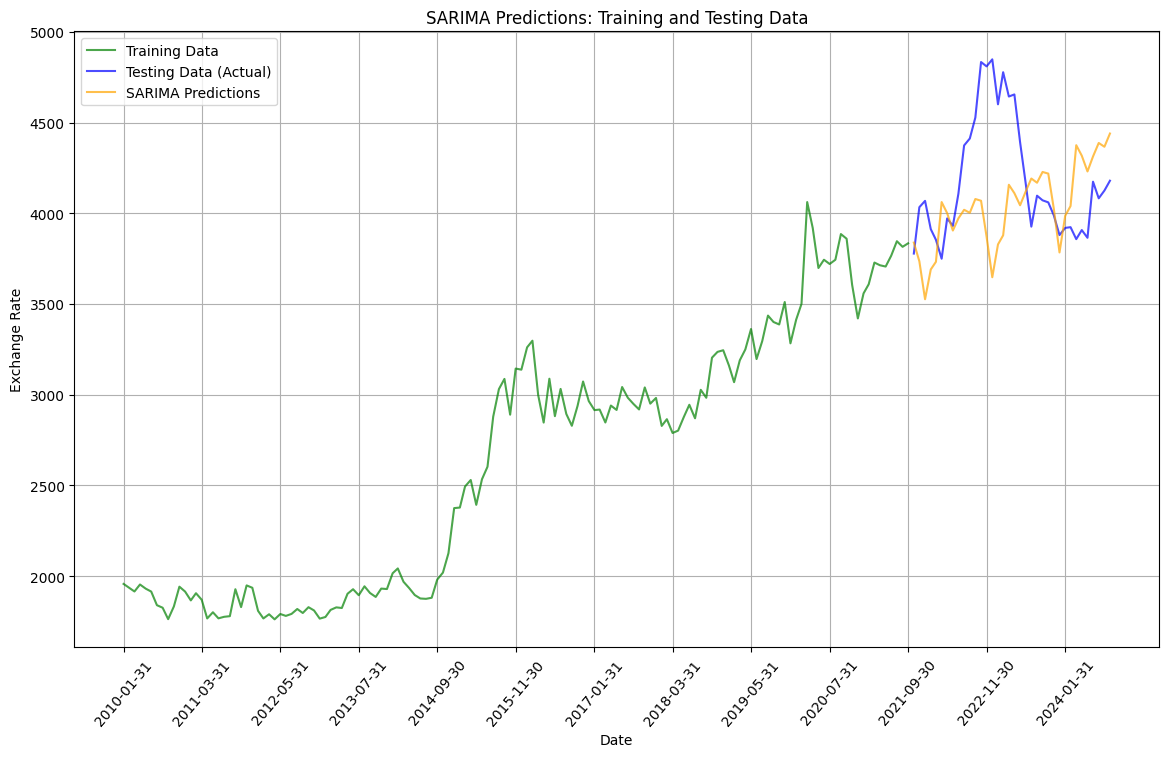

In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Add the 'Date' column back to train_data and test_data
train_data['Date'] = Monthly_data.iloc[:split_index]['Date'].values
test_data['Date'] = Monthly_data.iloc[split_index:]['Date'].values

# Define SARIMA parameters
order = (7, 1, 1)  # Non-seasonal
seasonal_order = (1, 2, 1, 12)  # Seasonal


sarima_model = SARIMAX(
    train_data['Exchange_Rate'],
    order=order,
    seasonal_order=seasonal_order
)
sarima_result = sarima_model.fit()
end_train_time = time.time()
train_time = end_train_time - start_train_time

# Measure prediction time
start_pred_time = time.time()
y_pred_sarima = sarima_result.forecast(steps=len(test_data))
end_pred_time = time.time()
pred_time = end_pred_time - start_pred_time

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred_sarima))
mae = mean_absolute_error(y_test, y_pred_sarima)
r2 = r2_score(y_test, y_pred_sarima)

# Display performance metrics and timing
print(f"SARIMA - RMSE: {rmse:.2f}")
print(f"SARIMA - MAE: {mae:.2f}")
print(f"SARIMA - R²: {r2:.2f}")
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {pred_time:.4f} seconds")

# Plot training, testing, and predictions
plt.figure(figsize=(14, 8))

# Training data
plt.plot(train_data['Date'], train_data['Exchange_Rate'], label='Training Data', color='green', alpha=0.7)

# Testing data (actual)
plt.plot(test_data['Date'], y_test, label='Testing Data (Actual)', color='blue', alpha=0.7)

# Testing data (predicted)
plt.plot(test_data['Date'], y_pred_sarima, label='SARIMA Predictions', color='orange', alpha=0.7)

# Customize the plot
plt.title('SARIMA Predictions: Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)

# Customize x-axis labels
all_dates = np.concatenate([train_data['Date'], test_data['Date']])
tick_spacing = len(all_dates) // 12
plt.xticks(
    ticks=all_dates[::tick_spacing],
    labels=pd.to_datetime(all_dates[::tick_spacing]).strftime('%Y-%m-%d'),
    rotation=50
)

plt.show()


In [54]:
# Update timing_data_df
timing_data_df = pd.concat([
    timing_data_df,
    pd.DataFrame({
        'Model': ['SARIMA'],
        'Training Time (s)': [train_time],
        'Prediction Time (s)': [pred_time]
    })
], ignore_index=True)

# Update performance_data_df
performance_data_df = pd.concat([
    performance_data_df,
    pd.DataFrame({
        'Model': ['SARIMA'],
        'RMSE': [rmse],
        'MAE': [mae],
        'R²': [r2]
    })
], ignore_index=True)

# Update predictions_df
predictions_df = pd.concat([
    predictions_df,
    pd.DataFrame({
        'Model': ['SARIMA'] * len(test_data),
        'Date': test_data['Date'],
        'Prediction': y_pred_sarima
    })
], ignore_index=True)

In [55]:
# Retrieve fitted parameters
print("Model Parameters:")
print(sarima_result.params)

# Retrieve the orders
print(f"Non-seasonal order: {sarima_model.order}")
print(f"Seasonal order: {sarima_model.seasonal_order}")

Model Parameters:
ar.L1          -1.175777
ar.L2          -0.221457
ar.L3          -0.100815
ar.L4          -0.020365
ar.L5           0.057000
ar.L6           0.284231
ar.L7           0.267469
ma.L1           0.995141
ar.S.L12       -0.414206
ma.S.L12       -0.995802
sigma2      18544.292463
dtype: float64
Non-seasonal order: (7, 1, 1)
Seasonal order: (1, 2, 1, 12)


#### 4.7 SARIMAX

In [56]:
# Measure training time
start_train_time = time.time()

# Ensure the data is sorted by date
Monthly_data = Monthly_data.sort_values('Date')

# Split data based on time (80% train, 20% test)
split_index = int(len(Monthly_data) * 0.8)
train_data = Monthly_data.iloc[:split_index].copy()  # Create a copy to avoid SettingWithCopyWarning
test_data = Monthly_data.iloc[split_index:].copy()

# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Transform the training set
train_data[['Interest Rate', 'IPC']] = minmax_scaler.fit_transform(train_data[['Interest Rate', 'IPC']])
train_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'PIB', 'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']] = standard_scaler.fit_transform(
    train_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'PIB', 'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']]
)

# Apply the same transformations to the test set using parameters from the training set
test_data[['Interest Rate', 'IPC']] = minmax_scaler.transform(test_data[['Interest Rate', 'IPC']])
test_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'PIB', 'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']] = standard_scaler.transform(
    test_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'PIB', 'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']]
)

# Define features and target
X_train = train_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'Interest Rate', 'IPC', 'PIB', 
                      'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']]
y_train = train_data['Exchange_Rate']
X_test = test_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'Interest Rate', 'IPC', 'PIB', 
                    'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']]
y_test = test_data['Exchange_Rate']

In [57]:
# First differencing
train_data_diff = train_data['Exchange_Rate'].diff().dropna()
y_train_diff = y_train.diff().dropna()

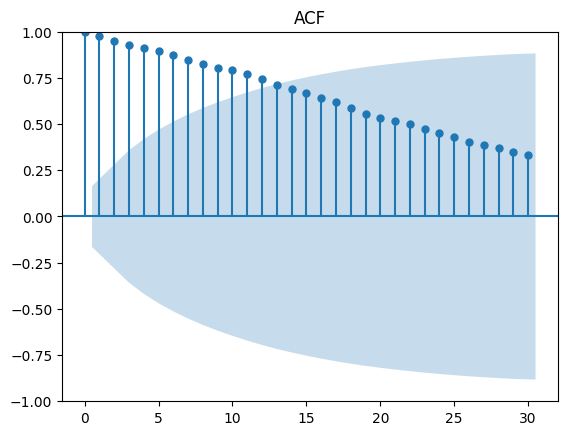

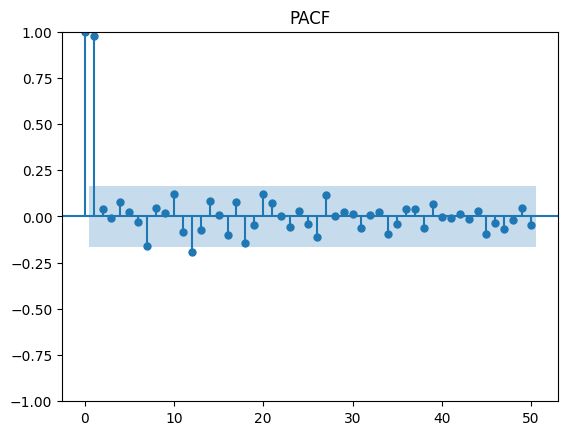

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for seasonal and non-seasonal terms
plot_acf(y_train, lags=30)
plt.title('ACF')
plt.show()

plot_pacf(y_train, lags=50)
plt.title('PACF')
plt.show()

d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:83

Training Time: 21.1354 seconds
Prediction Time: 0.0147 seconds
SARIMAX - RMSE: 395.82
SARIMAX - MAE: 303.17
SARIMAX - R²: -0.48


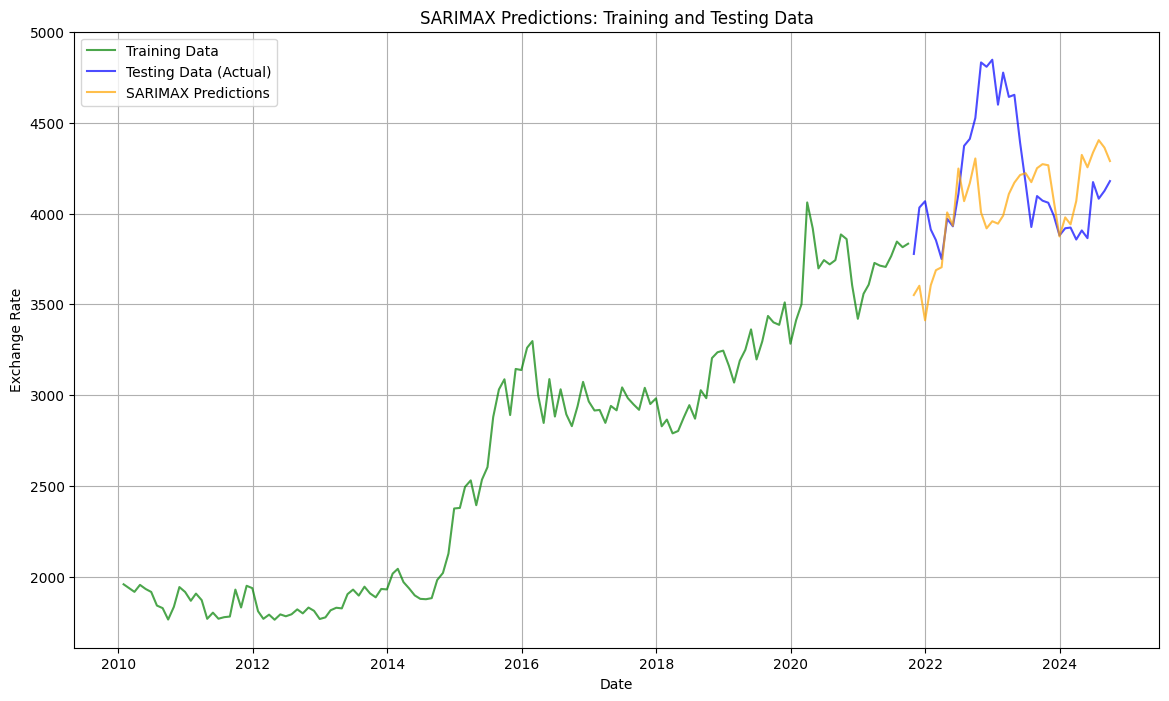

In [59]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 1: Prepare Data (Add 'Date' column back for plotting)
train_data['Date'] = Monthly_data.iloc[:split_index]['Date'].values
test_data['Date'] = Monthly_data.iloc[split_index:]['Date'].values

test_data['Date'] = pd.to_datetime(test_data['Date'])

# Step 2: Define SARIMAX Parameters
order = (2, 1, 11)  # Non-seasonal (p, d, q)
seasonal_order = (2, 1, 2, 12)  # Seasonal (P, D, Q, m)


sarimax_model = SARIMAX(
    train_data['Exchange_Rate'],  # Target variable
    exog=X_train,  # Exogenous variables
    order=(2, 1, 11),  # Non-seasonal (p, d, q)
    seasonal_order=(2, 1, 2, 12)  # Seasonal (P, D, Q, m)
).fit()
end_train_time = time.time()

train_time = end_train_time - start_train_time

# Measure prediction time
start_pred_time = time.time()
y_pred_sarimax = sarimax_model.forecast(steps=len(X_test), exog=X_test)
y_pred_sarimax = pd.Series(y_pred_sarimax)
end_pred_time = time.time()

pred_time = end_pred_time - start_pred_time

# Display timing information
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {pred_time:.4f} seconds")

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_sarimax))
mae = mean_absolute_error(y_test, y_pred_sarimax)
r2 = r2_score(y_test, y_pred_sarimax)

print(f"SARIMAX - RMSE: {rmse:.2f}")
print(f"SARIMAX - MAE: {mae:.2f}")
print(f"SARIMAX - R²: {r2:.2f}")

# Step 5: Plot Results
plt.figure(figsize=(14, 8))

# Training Data
plt.plot(train_data['Date'], y_train, label='Training Data', color='green', alpha=0.7)

# Testing Data (Actual)
plt.plot(test_data['Date'], y_test, label='Testing Data (Actual)', color='blue', alpha=0.7)

# Predictions
plt.plot(test_data['Date'], y_pred_sarimax, label='SARIMAX Predictions', color='orange', alpha=0.7)

# Customize the Plot
plt.title('SARIMAX Predictions: Training and Testing Data')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [60]:
# Extract coefficients for exogenous variables
coefficients = sarimax_model.params

# Filter only the exogenous variable coefficients
exog_coefficients = coefficients[X_train.columns]

# Normalize coefficients to represent relative importance (optional)
importance = exog_coefficients.abs() / exog_coefficients.abs().sum()

# Create a DataFrame for feature importance
sarimax_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': exog_coefficients.values,
    'Importance': importance.values
}).sort_values(by='Importance', ascending=False)

# Create the SARIMAX feature importance data
sarimax_feature_importance['Model'] = 'SARIMAX'

# Add SARIMAX data to the existing feature_importance_df
feature_importance_df = pd.concat([feature_importance_df, sarimax_feature_importance], ignore_index=True)

In [61]:
sarimax_feature_importance

,Feature,Coefficient,Importance,Model
3,Interest Rate,-469.833524,0.355190,SARIMAX
1,SP500_Index,-430.984509,0.325820,SARIMAX
4,IPC,119.141866,0.090070,SARIMAX
5,PIB,108.139766,0.081753,SARIMAX
0,Oil_Price,-96.428313,0.072899,SARIMAX
7,Exchange_Rate_Lag85,34.209895,0.025862,SARIMAX
2,Coffee_Price,-32.034400,0.024218,SARIMAX
6,Exchange_Rate_Lag30,-31.995973,0.024189,SARIMAX


In [62]:
# Update timing_data_df
timing_data_df = pd.concat([
    timing_data_df,
    pd.DataFrame({
        'Model': ['SARIMAX'],
        'Training Time (s)': [train_time],
        'Prediction Time (s)': [pred_time]
    })
], ignore_index=True)

# Update performance_data_df
performance_data_df = pd.concat([
    performance_data_df,
    pd.DataFrame({
        'Model': ['SARIMAX'],
        'RMSE': [rmse],
        'MAE': [mae],
        'R²': [r2]
    })
], ignore_index=True)


# Update predictions_df
sarimax_predictions_df = pd.DataFrame({
    'Model': ['SARIMAX'] * len(y_pred_sarimax),  # Length matches predictions
    'Date': test_data['Date'].values,  # Ensure values are aligned with predictions
    'Prediction': y_pred_sarimax.values  # Ensure predictions are a pandas Series/array
})

# Append to predictions_df
predictions_df = pd.concat([predictions_df, sarimax_predictions_df], ignore_index=True)


#### 4.8 Holt-Winters

d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Desktop\PORTFOLIO PROJECT\Exchange_rate_project\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Training Time: 0.3434 seconds
Prediction Time: 0.0065 seconds
Holt-Winters - RMSE: 383.66
Holt-Winters - MAE: 321.11
Holt-Winters - R²: -0.39


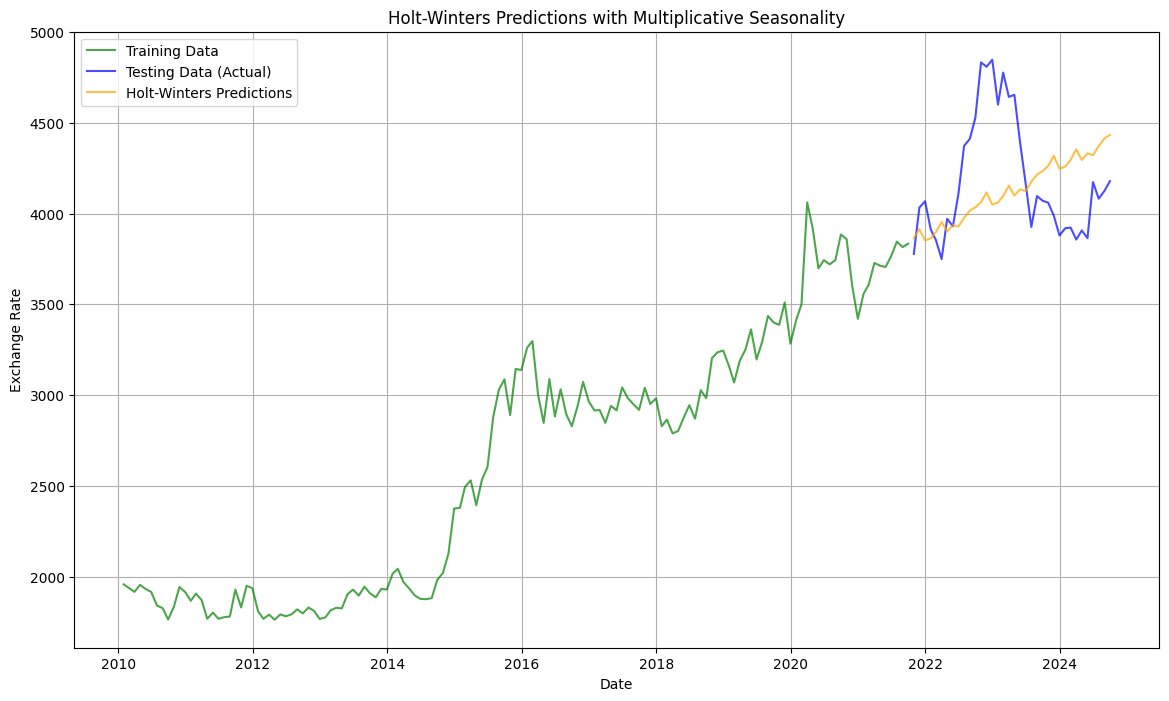

In [63]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Step 1: Fit the Holt-Winters model with multiplicative seasonality
# Measure training time
start_train_time = time.time()
holt_winters_model = ExponentialSmoothing(
    train_data['Exchange_Rate'],  # Target variable
    trend="add",                 # Additive trend
    seasonal="mul",              # Multiplicative seasonality
    seasonal_periods=12          # Seasonal period (12 for yearly seasonality in monthly data)
).fit()
end_train_time = time.time()

train_time = end_train_time - start_train_time

# Measure prediction time
start_pred_time = time.time()

# Step 2: Generate predictions for the test set
steps_to_forecast = len(test_data)
y_pred_hw = holt_winters_model.forecast(steps=steps_to_forecast)
end_pred_time = time.time()

pred_time = end_pred_time - start_pred_time

# Display timing information
print(f"Training Time: {train_time:.4f} seconds")
print(f"Prediction Time: {pred_time:.4f} seconds")

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_hw))
mae = mean_absolute_error(y_test, y_pred_hw)
r2 = r2_score(y_test, y_pred_hw)

print(f"Holt-Winters - RMSE: {rmse:.2f}")
print(f"Holt-Winters - MAE: {mae:.2f}")
print(f"Holt-Winters - R²: {r2:.2f}")

# Step 4: Plot training data, actual test data, and predictions
plt.figure(figsize=(14, 8))

# Plot training data
plt.plot(train_data['Date'], train_data['Exchange_Rate'], label='Training Data', color='green', alpha=0.7)

# Plot testing data (actual)
plt.plot(test_data['Date'], y_test, label='Testing Data (Actual)', color='blue', alpha=0.7)

# Plot predictions
plt.plot(test_data['Date'], y_pred_hw, label='Holt-Winters Predictions', color='orange', alpha=0.7)

# Customize the plot
plt.title('Holt-Winters Predictions with Multiplicative Seasonality')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


In [64]:
# Update timing_data_df
timing_data_df = pd.concat([
    timing_data_df,
    pd.DataFrame({
        'Model': ['Holt-Winters'],
        'Training Time (s)': [train_time],
        'Prediction Time (s)': [pred_time]
    })
], ignore_index=True)

# Update performance_data_df
performance_data_df = pd.concat([
    performance_data_df,
    pd.DataFrame({
        'Model': ['Holt-Winters'],
        'RMSE': [rmse],
        'MAE': [mae],
        'R²': [r2]
    })
], ignore_index=True)

hw_predictions_df = pd.DataFrame({
    'Model': ['Holt-Winters'] * steps_to_forecast,
    'Date': test_data['Date'].values[:steps_to_forecast],  # Align lengths
    'Prediction': y_pred_hw[:steps_to_forecast]  # Align lengths
})

# Combine with existing predictions DataFrame
predictions_df = pd.concat([predictions_df, hw_predictions_df], ignore_index=True)

In [65]:
# Ordenar el DataFrame por la columna "Training Time (s) en orden descendente
timing_data_df = timing_data_df.sort_values(by="Training Time (s)", ascending=True)

timing_data_df

,Model,Training Time (s),Prediction Time (s),Training Time (seconds),Prediction Time (seconds)
2,Linear Regression,0.046110,0.016256,NaN,NaN
0,XGBoost,0.237597,0.009676,NaN,NaN
7,Holt-Winters,0.343375,0.006478,NaN,NaN
3,Prophet,1.986920,0.198407,NaN,NaN
5,SARIMA,7.711856,0.014876,NaN,NaN
6,SARIMAX,21.135356,0.014666,NaN,NaN
4,"ARIMA(10, 1, 27)",277.844581,0.015322,NaN,NaN
1,Random Forest,NaN,NaN,0.578129,0.0173


In [66]:
# Ordenar el DataFrame por la columna "MAE" en orden descendente
performance_data_df = performance_data_df.sort_values(by="MAE", ascending=True)

# Mostrar el DataFrame ordenado
print(performance_data_df)

               Model         RMSE          MAE         R²
6            SARIMAX   395.823547   303.168265  -0.477246
7       Holt-Winters   383.655828   321.110850  -0.387820
3            Prophet   393.415786   323.201336  -0.459329
5             SARIMA   440.671359   337.988053  -0.830962
4   ARIMA(10, 1, 27)   464.750256   342.008484  -1.036521
2  Linear Regression   410.941165   345.633110  -0.592241
1      Random Forest   860.373111   778.025709  -5.979483
0            XGBoost  1313.170333  1234.023749 -15.258922


In [ ]:
feature_importance_df

,Model,Feature,Importance,Coefficient
0,XGBoost,Oil_Price,0.004122,NaN
1,XGBoost,SP500_Index,0.000391,NaN
2,XGBoost,Coffee_Price,0.001620,NaN
3,XGBoost,Exchange_Rate_Lag30,0.000937,NaN
4,XGBoost,Exchange_Rate_Lag85,0.001639,NaN
5,XGBoost,Interest Rate,0.035919,NaN
6,XGBoost,IPC,0.000215,NaN
7,XGBoost,PIB,0.003361,NaN
8,XGBoost,Time_Index,0.951796,NaN
9,Random Forest,Time_Index,0.894041,NaN


In [68]:
predictions_df

,Model,Date,Prediction
0,Random Forest,2021-10-31,3765.708411
1,Random Forest,2021-11-30,3744.224500
2,Random Forest,2021-12-31,3768.150906
3,Random Forest,2022-01-31,3407.059404
4,Random Forest,2022-02-28,3372.022705
...,...,...,...
283,Holt-Winters,2024-05-31,4331.924425
284,Holt-Winters,2024-06-30,4321.616169
285,Holt-Winters,2024-07-31,4373.091781
286,Holt-Winters,2024-08-31,4414.522999


In [69]:
# Define file paths
timing_data_path = r"Data/Output/timing_data.csv"
performance_data_path = r"Data/Output/performance_data.csv"
feature_importance_data_path = r"Data/Output/feature_importance_data.csv"
predictions_data_path = r"Data/Output/predictions.csv"

# Save dataframes to CSV
timing_data_df.to_csv(timing_data_path, index=False)
performance_data_df.to_csv(performance_data_path, index=False)
feature_importance_df.to_csv(feature_importance_data_path, index=False)
predictions_df.to_csv(predictions_data_path, index=False)

In [70]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd

# Initialize scalers
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Transform the entire dataset
transformed_data = Monthly_data.copy()

# Apply transformations
transformed_data[['Interest Rate', 'IPC']] = minmax_scaler.fit_transform(transformed_data[['Interest Rate', 'IPC']])
transformed_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'PIB', 'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']] = standard_scaler.fit_transform(
    transformed_data[['Oil_Price', 'SP500_Index', 'Coffee_Price', 'PIB', 'Exchange_Rate_Lag30', 'Exchange_Rate_Lag85']]
)

# Define the output file path
output_path = r"Data/Output/transformed_monthly_data.csv"

# Save the transformed dataframe as a CSV file
transformed_data.to_csv(output_path, index=False)